# Use Case Tutorial: Retail Demand Forecasting using DataRobot Python API and Time-series Helper Functions

# Part 2: Retrieving results, Model Evaluation, Performance Insights, Model Iteration and Improvement, Model Deployment, Getting Predictions

### In this use case, we are forecasting Candy sales for the next month from a single store. The store owner wants to decide which types and how much of each candy to stock for the next month, and potentially limit inventory to only high sales items. We have over 2 years of historical transaction data from the candy store. 

In [1]:
# import packages
import datarobot as dr
import datarobot_ts_helpers as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# set pandas configuration to show all columns
pd.set_option('display.max_columns', None)

### Connect to DataRobot Python API Client

In [2]:
# configure connection to DataRobot
# endpoint and API-token are stored in a config file
# US-server
dr.Client(config_path='/Users/jarred.bultema/.config/datarobot/drconfig.yaml', connect_timeout= 50000)


---------------

# Import Dataset

In [3]:
# upload the clustered data from the previous notebook
df_w_clusters = pd.read_csv('data/data_for_modeling_clustered.csv', index_col= None)
df_w_clusters['date'] = pd.to_datetime(df_w_clusters['date'])

In [4]:
df_w_clusters.head()

item_name       date  package_id_min  package_id_max  package_id_unique  \
0  Milky Way 2017-04-21    1.700000e+09    1.700000e+09                1.0   
1  Milky Way 2017-04-22             NaN             NaN                NaN   
2  Milky Way 2017-04-23    1.700000e+09    1.700000e+09                1.0   
3  Milky Way 2017-04-24    1.700000e+09    1.700000e+09                1.0   
4  Milky Way 2017-04-25    1.700000e+09    1.700000e+09                1.0   

      campaign_min     campaign_max  campaign_unique  qty_min  qty_mean  \
0  discount_type_1  discount_type_1              1.0     1.98      2.97   
1              NaN              NaN              NaN      NaN       NaN   
2  discount_type_1  discount_type_1              1.0     1.98      1.98   
3  discount_type_1  discount_type_1              1.0     2.00      2.98   
4  discount_type_1  discount_type_1              1.0     2.01      7.19   

   qty_max  qty_stdev  qty_unique  qty_sum  unit_price_min  unit_price_mean  \
0     3.96   1.400071         2.0     5.94            1.37         1.640000   
1      NaN        NaN         NaN      NaN             NaN              NaN   
2     1.98        NaN         1.0     1.98            3.05         3.050000   
3     3.96   1.385929         2.0     5.96            1.67         2.505000   
4    15.63   7.372029         3.0    21.57            0.01         1.643333   

   unit_price_max  unit_price_stdev  unit_price_unique  unit_price_sum  \
0            1.91          0.381838                2.0            3.28   
1             NaN               NaN                NaN             NaN   
2            3.05               NaN                1.0            3.05   
3            3.34          1.180868                2.0            5.01   
4            2.76          1.445971                3.0            4.93   

   sale_amount_min  sale_amount_mean  sale_amount_max  sale_amount_stdev  \
0             3.78          4.605000             5.43           1.166726   
1              NaN               NaN              NaN                NaN   
2             6.04          6.040000             6.04                NaN   
3             6.61          6.645000             6.68           0.049497   
4             0.02         14.876666            33.76          17.226648   

   sale_amount_unique  sale_amount_sum  day store_category category  \
0                 2.0         9.210000  Fri         Type_B   Retail   
1                 NaN         0.000000  NaN            NaN      NaN   
2                 1.0         6.040000  Sun         Type_B   Retail   
3                 2.0        13.290000  Mon         Type_B   Retail   
4                 3.0        44.629997  Tue         Type_B   Retail   

  transaction  aggregated_total_count  metro_area  county_1  \
0        Good                     2.0         NaN       NaN   
1         NaN                     NaN         NaN       NaN   
2        Good                     1.0         NaN       NaN   
3        Good                     2.0         NaN       NaN   
4        Good                     3.0         NaN       NaN   

   total_market_sales  metro_area_ffill  metro_area_interpolate  \
0                 NaN        44851296.0            4.405770e+07   
1                 NaN               NaN                     NaN   
2                 NaN        44851296.0            4.399837e+07   
3                 NaN        44851296.0            4.397612e+07   
4                 NaN        44851296.0            4.395016e+07   

   county_1_ffill  county_1_interpolate  total_market_sales_ffill  \
0      30626743.0          3.030658e+07                89702592.0   
1             NaN                   NaN                       NaN   
2      30626743.0          3.028265e+07                89702592.0   
3      30626743.0          3.027367e+07                89702592.0   
4      30626743.0          3.026320e+07                89702592.0   

   total_market_sales_interpolate  Cluster  sale_amount_sum_mean  \
0             


----------------

# Project Settings

### Configure the settings to be used in the Time Series problem in DataRobot

In [120]:
# Set default values
target= 'sale_amount_sum'
date_col = 'date'
series_id = 'item_name'
kia = [] #None # No columns known in advance
dnd= [] # None # define the DND variables here as a list of column-name-strings or leave as None
num_backtests = 3
validation_duration = 30 # want to predict 1-month sales, validating on the same period
holdout_duration = 30 
disable_holdout = False
metric = 'RMSE' # see discussion on metrics below, using 'RMSE' for simplicity
use_time_series = True
use_cross_series_features = False
fd_start = 1
fd_end = 31 # forecasting sales for the next month
fdw_start = -28 
fdw_end = 0
max_date = df_w_clusters['date'].max()
mode= dr.AUTOPILOT_MODE.QUICK # set the modeling mode
n_workers= -1 # you can limit the workers used per project (int) or use all (-1). I typically use 5-20 workers/project, but not all

# create Time Series settings
ts_settings = {'max_date':max_date, 'known_in_advance':kia, 'do_not_derive': dnd,
                'use_cross_series_features': use_cross_series_features,
               'num_backtests':num_backtests, 'validation_duration':validation_duration, 
               'holdout_duration':holdout_duration,'disable_holdout':disable_holdout,'use_time_series':use_time_series,
               'series_id':series_id, 'metric':metric, 'target':target, 'date_col':date_col,
               'fd_start':fd_start, 'fd_end':fd_end, 'fdw_start':fdw_start, 'fdw_end':fdw_end,
               'n_workers': n_workers, 'mode': mode}

## Lets briefly visualize the clustered data

In [6]:
# reshape the dataframe for dimensionality reduction
clusters_scaled = ts.reshape_df(df_w_clusters, ts_settings, scale= True)



In [7]:
# perform dimensionality reduction and plot the clustered data with labels
ts.plot_UMAP(clusters_scaled, df_w_clusters, ts_settings)

-----------------
# Retrieve Results from DataRobot Models

### Group the DataRobot projects of interest based in the prefix used when creating the projects

In [8]:
# if Projects have already been run with a specific naming context, 
# then it is easy to retrieve those project-objects with simple list comprehensions

# use the project-prefix set when projects are build
project_key = 'Demand_forecasting_tutorial_project_1'
project2_key = 'Demand_forecasting_tutorial_project_2'
project3_key = 'Demand_forecasting_tutorial_project_3'

# select only the desired DR-projects for each of the modeling runs performed
# stage == 'modeling' will only retrieve projects that successfully completed
projects = [x for x in dr.Project.list() if project_key in str(x) and x.stage == 'modeling']
projects2 = [x for x in dr.Project.list() if project2_key in str(x) and x.stage == 'modeling']
projects3 = [x for x in dr.Project.list() if project3_key in str(x) and x.stage == 'modeling']

In [11]:
print(f'Projects in {project_key}: ', len(projects))
print(f'Projects in {project2_key}: ', len(projects2))
print(f'Projects in {project3_key}: ', len(projects3))

Projects in Demand_forecasting_tutorial_project_1:  4
Projects in Demand_forecasting_tutorial_project_2:  28
Projects in Demand_forecasting_tutorial_project_3:  60


### Models have been built, now we need to compute the backtest scores for all backtests on all projects

In [9]:
%%time
# Get the results from completed projects
# Project 1
project_scores = ts.get_or_request_backtest_scores(projects, 
                                               n_models=5, 
                                               data_subset='allBacktests', 
                                               include_blenders=False, 
                                               metric='RMSE')

# Project 2
project2_scores = ts.get_or_request_backtest_scores(projects2, 
                                               n_models=5, 
                                               data_subset='allBacktests', 
                                               include_blenders=False, 
                                               metric='RMSE')

# Project 3
project3_scores = ts.get_or_request_backtest_scores(projects3, 
                                               n_models=5, 
                                               data_subset='allBacktests', 
                                               include_blenders=False, 
                                               metric='RMSE')

Scores for all 4 projects have been computed
Scores for all 28 projects have been computed
Scores for all 60 projects have been computed
CPU times: user 7.67 s, sys: 93.5 ms, total: 7.76 s
Wall time: 5min 48s


In [19]:
project_scores.head(1)

Project_Name  \
0  Demand_forecasting_tutorial_project_1_FD:1-30_...   

                 Project_ID                  Model_ID  \
0  6039410ccbbfae8d6a55be48  603945fc6347402bee80d05e   

                                          Model_Type              Featurelist  \
0  eXtreme Gradient Boosting Regressor with Early...  DR Reduced Features M18   

   Backtest_1_RMSE  Backtest_1_MASE  Backtest_1_Theils_U  Backtest_1_SMAPE  \
0         49.19254          0.85743              0.76711         107.57679   

   Backtest_1_R_Squared              All_Backtests_RMSE  \
0              -0.07854  [49.19254, 51.39446, 61.34819]   

            All_Backtests_MASE       All_Backtests_Theils_U  \
0  [0.85743, 0.99466, 0.78848]  [0.76711, 0.79302, 0.66412]   

                 All_Backtests_SMAPE        All_Backtests_R_Squared  \
0  [107.57679, 115.01064, 119.21306]  [-0.07854, -0.13366, 0.09266]   

  Holdout_RMSE Holdout_MASE Holdout_Theils_U Holdout_SMAPE Holdout_R_Squared  
0         None         None             None          None              None

In [10]:
# if you ever want info on functions, use the help command
help(ts.get_or_request_backtest_scores)

Help on function get_or_request_backtest_scores in module datarobot_ts_helpers.ts_projects:

get_or_request_backtest_scores(projects, n_models=5, data_subset='allBacktests', include_blenders=True, metric=None)
    Get or request backtest and holdout scores from top models across multiple DataRobot projects
    
    projects: list
        DataRobot project object(s)
    n_models: int
        Number of top models to return
    data_subset: str (optional)
        Can be set to either allBacktests or holdout
    include_blenders: boolean (optional)
        Controls whether to include ensemble models
    metric: str (optional)
        Project metric used to sort the DataRobot leaderboard
        Choose from list of 'MASE', 'RMSE', 'MAPE', 'SMAPE', 'MAE', 'R Squared', 'Gamma Deviance',
                            'SMAPE', 'Tweedie Deviance', 'Poisson Deviance', or 'RMSLE'
    
    Returns:
    --------
    pandas df



### A note on using blenders:
Including blenders in the 'best' models will limit the ability to iteratively retain models, and blenders as a whole cannot be retrained. Instead they must be rebuild from several retrained DataRobot blueprints. If retraining of models (for example with reduced feature lists) is anticipated, then blenders should be exclude from the get_or_request_backtest_scores() function call.

In [12]:
%%time
# this cell can only be executed after projects have completed
# any incomplete projects in the project-list will cause this function to error
ts.compute_backtests(projects, n_models=5, data_subset='allBacktests', include_blenders=True, metric='RMSE')
ts.compute_backtests(projects2, n_models=5, data_subset='allBacktests', include_blenders=True, metric='RMSE')
ts.compute_backtests(projects3, n_models=5, data_subset='allBacktests', include_blenders=True, metric='RMSE')

All available backtests have been submitted for scoring for project Demand_forecasting_tutorial_project_1_FD:1-30_FDW:-56_all_series
Computing backtests for model 60394634391c720907ee22e8 in Project Demand_forecasting_tutorial_project_1_FD:1-30_FDW:-28_all_series
All available backtests have been submitted for scoring for project Demand_forecasting_tutorial_project_1_FD:1-30_FDW:-28_all_series
All available backtests have been submitted for scoring for project Demand_forecasting_tutorial_project_1_FD:1-30_FDW:-56_all_series
All available backtests have been submitted for scoring for project Demand_forecasting_tutorial_project_1_FD:1-30_FDW:-28_all_series
Computing backtests for model 603953204a6697eaa180d0bb in Project Demand_forecasting_tutorial_project_2_FD:1-30_FDW:-56_Cluster-5
All available backtests have been submitted for scoring for project Demand_forecasting_tutorial_project_2_FD:1-30_FDW:-56_Cluster-5
Computing backtests for model 60395234e85441edc622378a in Project Demand_fo

### We can also look at the best scoring model for each project

#### For either the simple or complex (with a large number of projects) use, retrieving the best scores for a FDW is simple.

In [20]:
%%time
# project 1
scores_best = ts.filter_best_fdw_scores(project_scores, col_error='All_Backtests_RMSE')

# project 2
scores2_best = ts.filter_best_fdw_scores(project2_scores, col_error='All_Backtests_RMSE')

# project 3
scores3_best = ts.filter_best_fdw_scores(project3_scores, col_error='All_Backtests_RMSE')

CPU times: user 46.2 ms, sys: 4.84 ms, total: 51 ms
Wall time: 48.9 ms


### We may be more interested in understand which project gives the best results, this is especially relevant when a larger project has been broken into many smaller constituent projects

In [21]:
%%time
# this function will select the 'best' DataRobot project for any identical set of data
# this is how you can easily determine which FDW and FW worked best for each cluster in the data
projects_best = ts.filter_best_fdw_projects(project_scores, projects, col_error='All_Backtests_RMSE')
projects2_best = ts.filter_best_fdw_projects(project2_scores, projects2, col_error='All_Backtests_RMSE')
projects3_best = ts.filter_best_fdw_projects(project3_scores, projects3, col_error='All_Backtests_RMSE')

CPU times: user 60.8 ms, sys: 5.3 ms, total: 66.1 ms
Wall time: 68.3 ms


In [22]:
# what does this look like?
projects3_best

[Project(Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-5),
 Project(Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-56_Cluster-4),
 Project(Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-28_Cluster-4),
 Project(Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-3),
 Project(Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-14_Cluster-2),
 Project(Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-2),
 Project(Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-14_Cluster-1),
 Project(Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-1),
 Project(Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-62_Cluster-5),
 Project(Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-5),
 Project(Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-28_Cluster-4),
 Project(Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-62_Cluster-3),
 Project(Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-3),
 Project(Demand_fore

### We can evaluate performance on each cluster

Getting cluster accuracy...


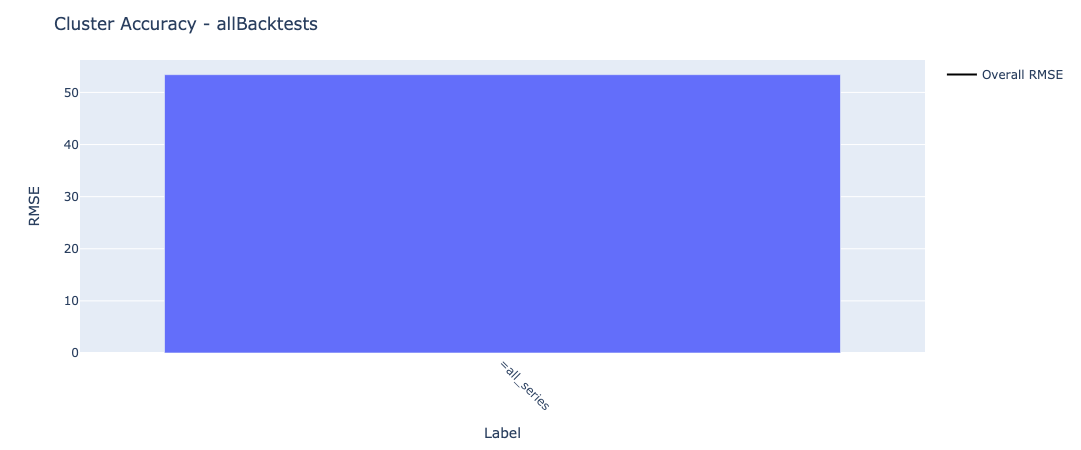

CPU times: user 30.7 s, sys: 994 ms, total: 31.7 s
Wall time: 1min 4s


In [23]:
%%time
cluster_acc = ts.get_cluster_acc(df_w_clusters, 
                                 projects_best, 
                                 ts_settings, 
                                 data_subset='allBacktests', 
                                 include_blenders=False, 
                                 metric='RMSE', 
                                 acc_calc=ts.rmse)
ts.plot_cluster_acc(cluster_acc, ts_settings, data_subset='allBacktests', acc_calc=ts.rmse)

### This provides a baseline for comparison as we look at more complex modeling options.

### This plotting is more relevant for more complex use where clusters were modeled in separate projects:

In [27]:
projects2_best

[Project(Demand_forecasting_tutorial_project_2_FD:1-30_FDW:-28_Cluster-5),
 Project(Demand_forecasting_tutorial_project_2_FD:1-30_FDW:-56_Cluster-4),
 Project(Demand_forecasting_tutorial_project_2_FD:1-30_FDW:-56_Cluster-3),
 Project(Demand_forecasting_tutorial_project_2_FD:1-30_FDW:-56_Cluster-2),
 Project(Demand_forecasting_tutorial_project_2_FD:1-30_FDW:-56_Cluster-1),
 Project(Demand_forecasting_tutorial_project_2_FD:16-30_FDW:-84_Cluster-1),
 Project(Demand_forecasting_tutorial_project_2_FD:1-15_FDW:-56_Cluster-1),
 Project(Demand_forecasting_tutorial_project_2_FD:1-15_FDW:-84_Cluster-2),
 Project(Demand_forecasting_tutorial_project_2_FD:16-30_FDW:-28_Cluster-2),
 Project(Demand_forecasting_tutorial_project_2_FD:16-30_FDW:-28_Cluster-0),
 Project(Demand_forecasting_tutorial_project_2_FD:1-15_FDW:-28_Cluster-0)]

Getting cluster accuracy...


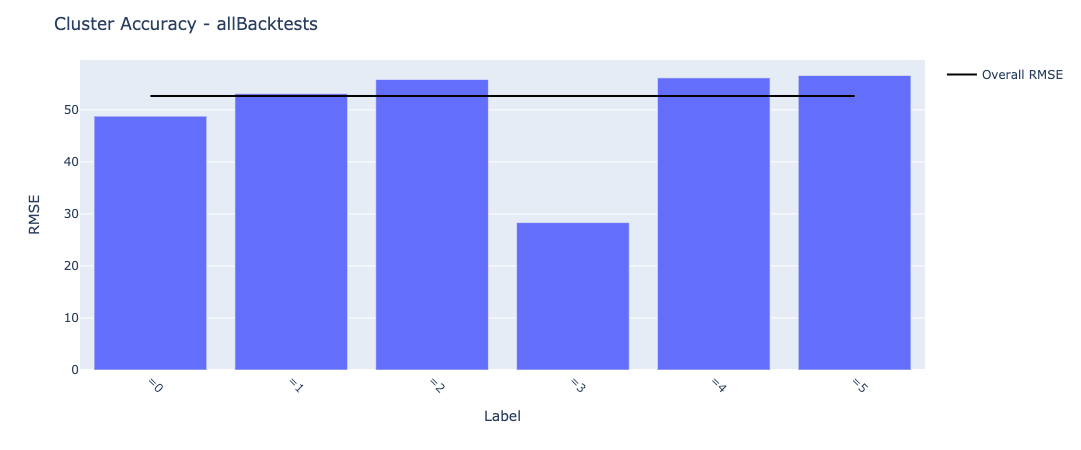

CPU times: user 29.5 s, sys: 755 ms, total: 30.3 s
Wall time: 1min 48s


In [26]:
%%time
cluster2_acc = ts.get_cluster_acc(df_w_clusters, 
                                 projects2_best, 
                                 ts_settings, 
                                 data_subset='allBacktests', 
                                 include_blenders=False, 
                                 metric='RMSE', 
                                 acc_calc=ts.rmse)
ts.plot_cluster_acc(cluster2_acc, ts_settings, data_subset='allBacktests', acc_calc=ts.rmse)

Getting cluster accuracy...


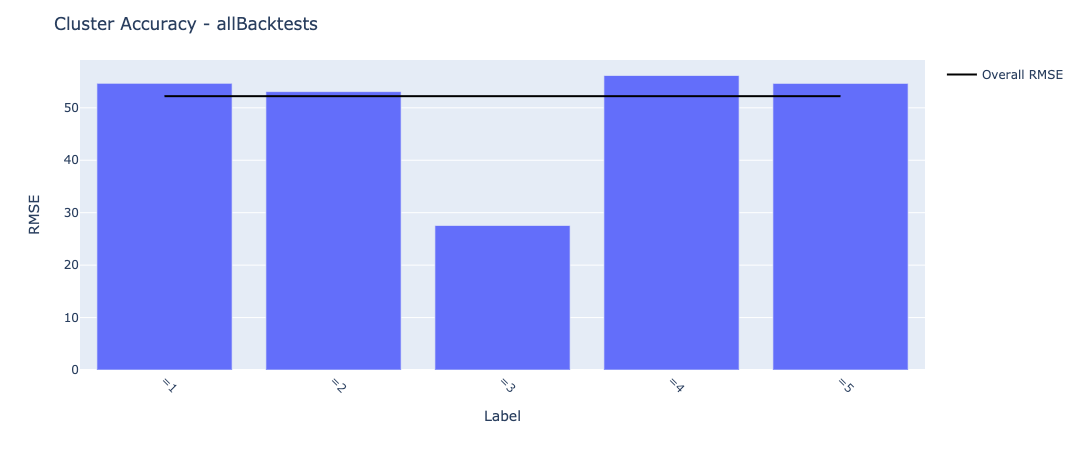

CPU times: user 27.9 s, sys: 929 ms, total: 28.8 s
Wall time: 12min 54s


In [25]:
%%time
cluster3_acc = ts.get_cluster_acc(df_w_clusters, 
                                 projects3_best, 
                                 ts_settings, 
                                 data_subset='allBacktests', 
                                 include_blenders=False, 
                                 metric='RMSE', 
                                 acc_calc=ts.rmse)
ts.plot_cluster_acc(cluster3_acc, ts_settings, data_subset='allBacktests', acc_calc=ts.rmse)

#### At a glance, we see the overall performance of these clustered datasets broken into more DataRobot projects has improved overall accuracy non-uniformly across clusters, with little change to overall accuracy with this small, demo dataset. 

##### Projects 2 (with 3 clusters) shows relatively little improvement, but Project 3 (5 clusters) shows clusters with better, worse, and equivalent performance to the non-clustered, single DR project (Project 1).

#### These weaker performing clusters provide a starting point to iterate on the weakest groups. Lets see if we can identify reasons that performance is weaker across some clusters and find ways to improve overall error.

## Which series are contributing to these high error rates?

Getting series accuracy...


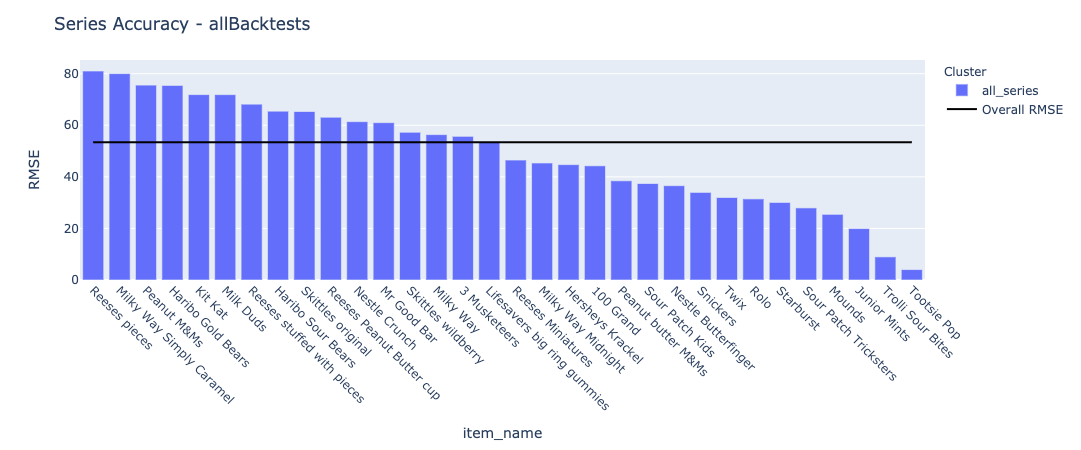

CPU times: user 31 s, sys: 783 ms, total: 31.8 s
Wall time: 59.5 s


In [28]:
%%time
series_acc = ts.get_series_acc(df_w_clusters, 
                               projects_best, 
                               ts_settings, 
                               data_subset='allBacktests', 
                               include_blenders=False, 
                               metric='RMSE', 
                               acc_calc=ts.rmse)
ts.plot_series_acc(series_acc, ts_settings, data_subset='allBacktests', acc_calc=ts.rmse, n= 50)

Getting series accuracy...


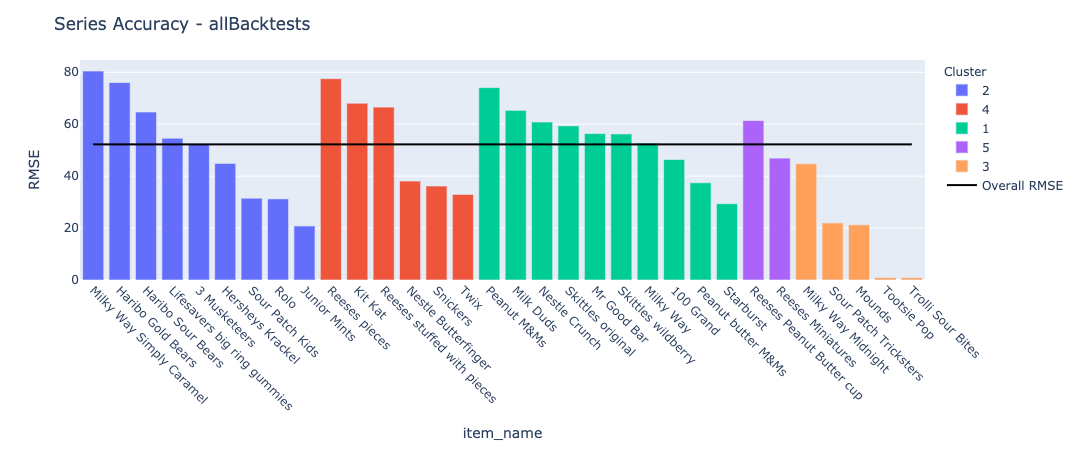

CPU times: user 30.5 s, sys: 845 ms, total: 31.3 s
Wall time: 4min 23s


In [30]:
%%time
series3_acc = ts.get_series_acc(df_w_clusters, 
                               projects3_best, 
                               ts_settings, 
                               data_subset='allBacktests', 
                               include_blenders=False, 
                               metric='RMSE', 
                               acc_calc=ts.rmse)
ts.plot_series_acc(series3_acc, ts_settings, data_subset='allBacktests', acc_calc=ts.rmse, n= 50)

-----------
# Evaluate Backtests

#### At this point, we notice a few things.
#### - Accuracy varies widely by series overall, and for the more complicated projects with many clusters, we see substantial variation within  those clusters.
#### - The overall accuracy is similar regardless of the number of clusters used. This might suggest that clustering isn't need for this dataset, but lets explore this a bit further to see if we can improve performance.

### How many series were included in the training data?

In [31]:
# checking displayed series
print('Number of series in the dataset: ', df_w_clusters['item_name'].unique().shape[0])
print('Projects 1: No clustering, 1 DR Project. Number of series shown on series accuracy plot: ',series_acc.shape[0])
print('Projects 2: Five Clusters, 48 DR project. Number of series shown on series accuracy plot: ',series2_acc.shape[0])
print('Projects 3: Eight Clusters, 48 DR project. Number of series shown on series accuracy plot: ',series3_acc.shape[0])

Number of series in the dataset:  49
Projects 1: No clustering, 1 DR Project. Number of series shown on series accuracy plot:  32
Projects 2: Five Clusters, 48 DR project. Number of series shown on series accuracy plot:  57
Projects 3: Eight Clusters, 48 DR project. Number of series shown on series accuracy plot:  32


### There are series missing from these plots. Why?


Getting backtest information for all projects...


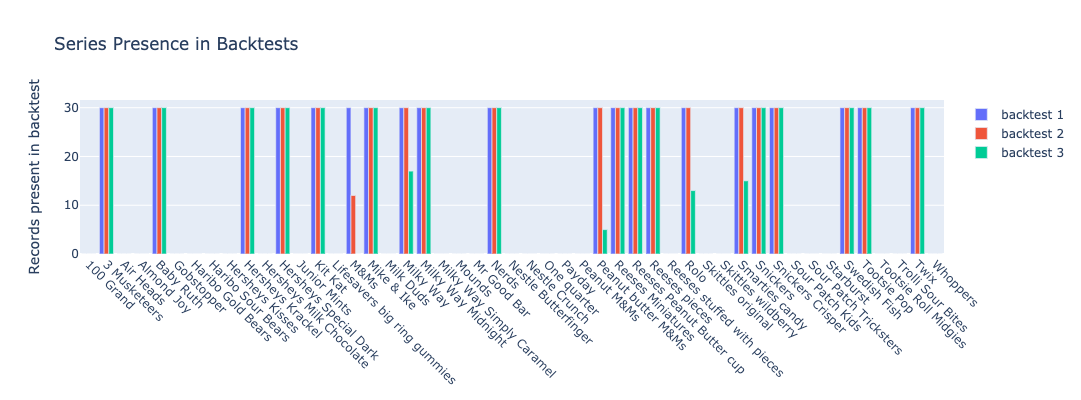

CPU times: user 770 ms, sys: 24.1 ms, total: 794 ms
Wall time: 5.3 s


In [32]:
%%time
# calculate how many records are present for all series in backtests
projects_backtesting_info = ts.get_training_and_backtest_windows(projects_best, ts_settings, data_subset='allBacktests', metric= None)
projects_backtests = ts.check_all_series_backtests(df_w_clusters, ts_settings, projects_backtesting_info)
ts.plot_series_backtest_coverage(projects_backtests, ts_settings, n=50)

Getting backtest information for all projects...


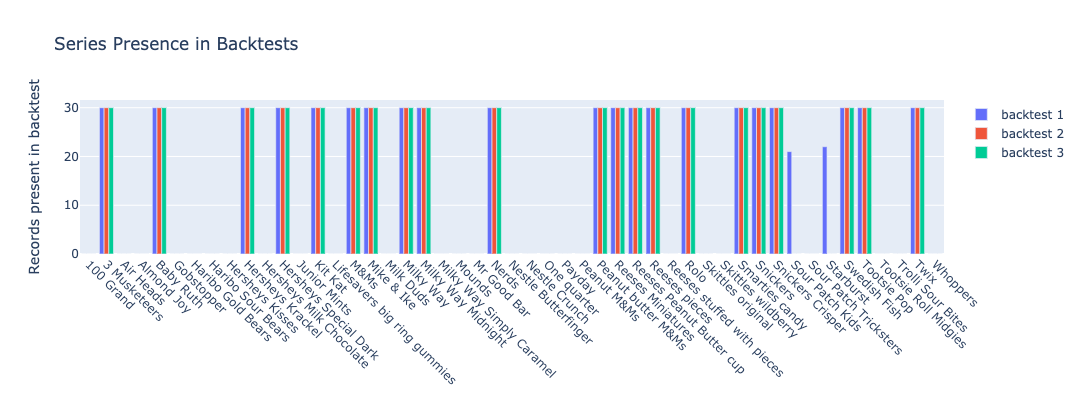

CPU times: user 1.27 s, sys: 180 ms, total: 1.45 s
Wall time: 22.1 s


In [35]:
%%time
# calculate how many records are present for all series in backtests
projects2_backtesting_info = ts.get_training_and_backtest_windows(projects2_best, ts_settings, data_subset='allBacktests', metric= None)
projects2_backtests = ts.check_all_series_backtests(df_w_clusters, ts_settings, projects2_backtesting_info)
ts.plot_series_backtest_coverage(projects2_backtests, ts_settings, n=50)

Getting backtest information for all projects...


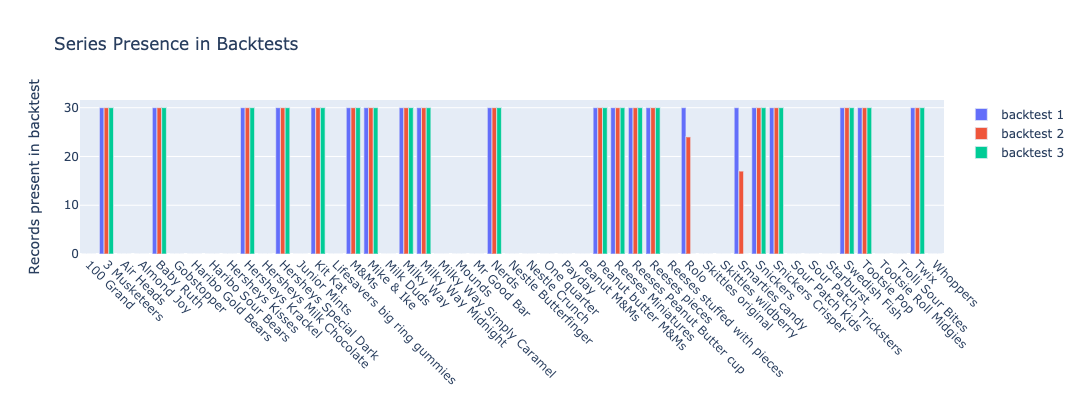

CPU times: user 2.66 s, sys: 54.7 ms, total: 2.71 s
Wall time: 2min 2s


In [36]:
%%time
# calculate how many records are present for all series in backtests
projects3_backtesting_info = ts.get_training_and_backtest_windows(projects3_best, ts_settings, data_subset='allBacktests', metric= None)
projects3_backtests = ts.check_all_series_backtests(df_w_clusters, ts_settings, projects3_backtesting_info)
ts.plot_series_backtest_coverage(projects3_backtests, ts_settings, n=50)

#### An interesting results in this case is that series that do not have sales history over the validation windows are not present in this analysis.

#### We also notice that presence in backtests is not consistent across the different projects. This is because backtests dates were not set explicitly and there are many short series that aren't present in any of the backtests.

## Plot these series and see if it provides insight

In [41]:
%%time
# get the series present and absent from the backtests
present_series = ts.get_series_in_backtests(projects3_backtests, data_subset= 'allBacktests', present= True, threshold= 1.0)
absent_series = ts.get_series_in_backtests(projects3_backtests, data_subset= 'allBacktests', present= False, threshold= 0.25)
print(f'Number series present: ', len(present_series))
print(f'Number series absent: ', len(absent_series))


# subset the dataframes based on series presence in backtests
df_present = df_w_clusters[df_w_clusters['item_name'].isin(present_series)].copy()
df_absent = df_w_clusters[df_w_clusters['item_name'].isin(absent_series)].copy()

Getting series with present in 30 or more rows in backtest_1, backtest_2, backtest_3 ...
Getting series with present in 7 or fewer rows rows in backtest_1, backtest_2, backtest_3 ...
Number series present:  21
Number series absent:  30
CPU times: user 16.1 ms, sys: 6.57 ms, total: 22.6 ms
Wall time: 23.4 ms


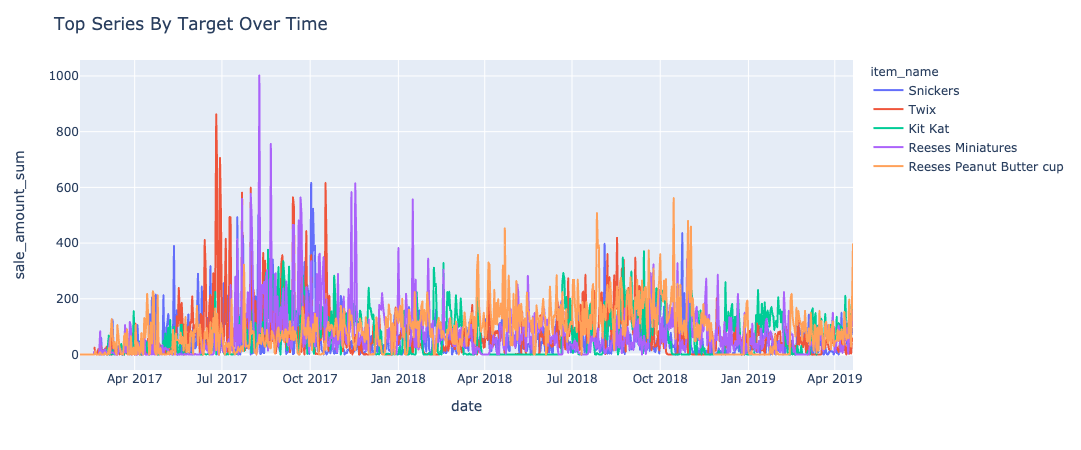

In [42]:
ts.plot_individual_series(df_present, ts_settings, n=5, top= True)

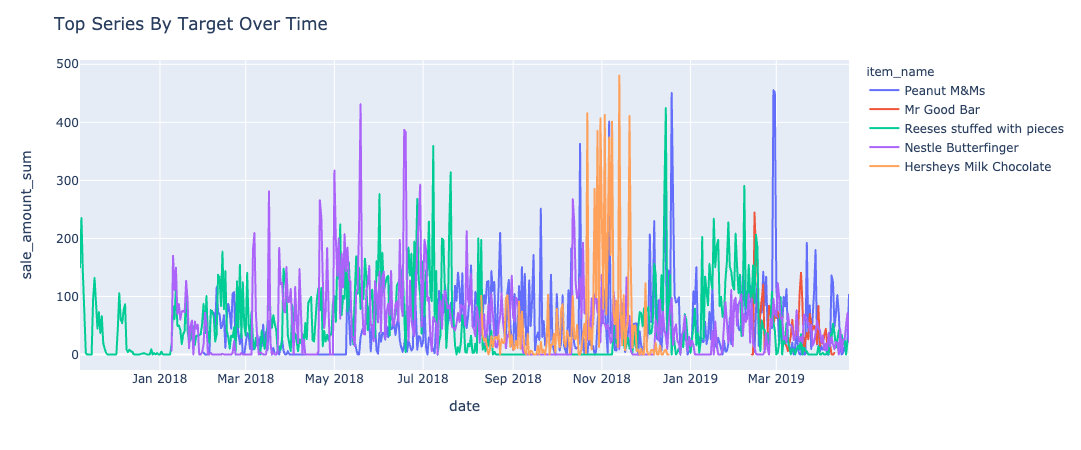

In [43]:
ts.plot_individual_series(df_absent, ts_settings, n=5, top= True)

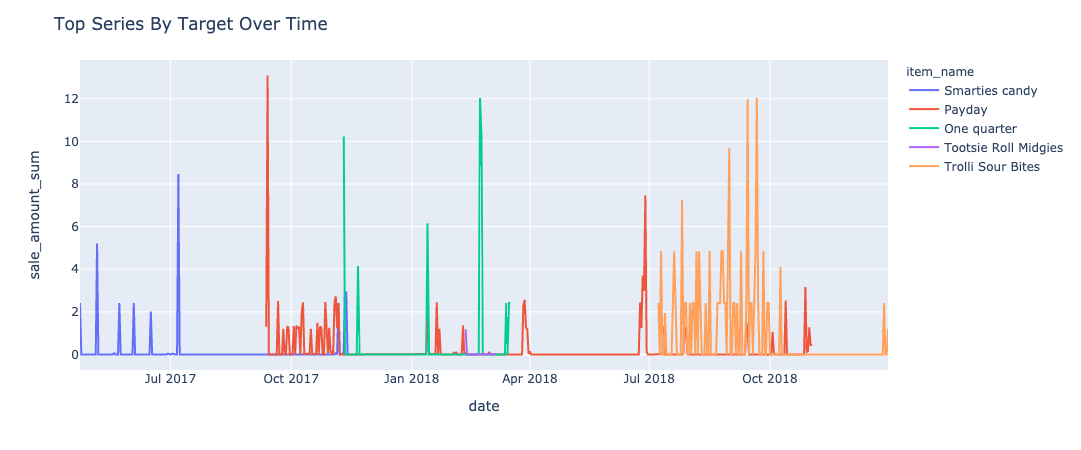

In [44]:
ts.plot_individual_series(df_absent, ts_settings, n=5, top=False)

#### - We see that some of these series absent from backtests are quite short. We could consider alternate strategies to handle this short series using a cold-start modeling approach to deal with this. But we won't go too far in that direction in this tutorial and we'll save that for another tutorial. A simple approach is to ensure you are using the DataRobot blueprints with additional 'New Series' support. Those BPs can be found by searching the Repository by name.

#### - You may also notice that some of the series absent from backtests are relatively continuous, but have missed the backtest windows. We could address this by changing the number, length, or specific dates associated with the backtest windows. Again, we won't pursue that here, but that would only require changing the ts_settings file and kicking off more projects.

-----------------
# Retrain models on reduced features

### To potentially improve performance, models can be retrained on a reduced feature set. Model ranking by Backtest or Holdout data is available, and requires no additional modification of the inputs.

## Different strategies
- use feature impact to select for most relevant features
- use Elastic net or ridge regressor coefficients (per Forecast Distance) to find features that have an out-sized effect (extremely high coefficient that is substantially larger in either direction), include it in a reduced feature list. It may represent extremely important but uncommon events (e.x. US sales on Black Friday)

#### There are functions in the datarobot_ts_helpers package to allow you to retrain specific BPs within Projects. Or...

# Automating Feature Selection using iterative feature thresholding

### Steps in the process
1. Start with Quick Mode
2. Get Feature Impact on the Best Model
3. Generate Top-N Feature Lists at 20%, 40%, 60%, 80% of all the features (by default 60% - 100%). Pick the step-size
4. Train the Best Model on those reduced feature lists
5. Go take a walk while this runs
6. Plot the results
7. Automatically select the best model from each project - your model using reduced features may now top the leaderboard


#### These checks have been automated in the function that allows you to run this for multiple DataRobot projects, as below:

In [58]:
%%time
# perform this for all of the projects
# note: this has already been run for these projects (projects3_best)
# outputs will show an error that these featurelist already exist
all_projects = ts.run_feature_selection_projects(df_w_clusters, projects3_best, ts_settings, threshold_range= (0.4, 1.0), step_size = 0.05)
all_projects.shape

Getting ranked models from 17 projects ...
Training reduced feature lists for 17 projects ...

Retraining the 1-ranked model ...
------------
422 client error: {'message': 'Feature list named Top 41 features M24 already exists'}
422 client error: {'message': 'Feature list named Top 33 features M24 already exists'}
422 client error: {'message': 'Feature list named Top 28 features M24 already exists'}
422 client error: {'message': 'Feature list named Top 23 features M24 already exists'}
422 client error: {'message': 'Feature list named Top 20 features M24 already exists'}
422 client error: {'message': 'Feature list named Top 17 features M24 already exists'}
422 client error: {'message': 'Feature list named Top 15 features M24 already exists'}
422 client error: {'message': 'Feature list named Top 13 features M24 already exists'}
422 client error: {'message': 'Feature list named Top 11 features M24 already exists'}
422 client error: {'message': 'Feature list named Top 9 features M24 alread

(218, 20)

### Plot the results:

All_Backtests_RMSE


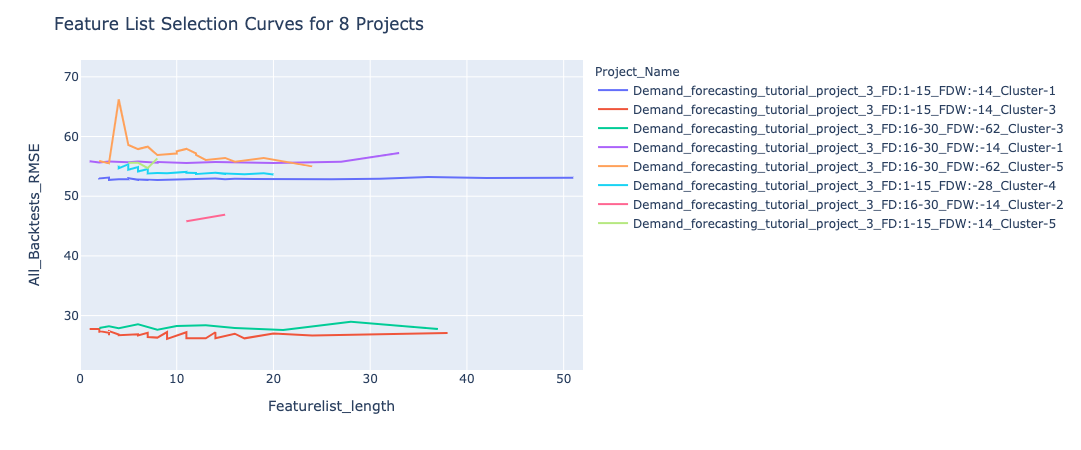

CPU times: user 77.2 ms, sys: 20.1 ms, total: 97.3 ms
Wall time: 121 ms


In [59]:
%%time
ts.plot_all_featurelist_curves(all_projects, ts_settings, data_subset= 'allBacktests', metric= 'RMSE')

### Evaluation of automated feature list reduction for these projects provides variable lift, but demonstrates the ability to automatically attempt to improve performance any any number of projects

--------
# Run the Repo...

#### When all else fails and you've got time, then you can consider running many models from the repository. By default, this function will use the featurelist from the DataRobot recommended blueprint. If you want to be 'insane', you can run the repo on the featurelist from the top-5 blueprints on the leaderboard.

In [60]:
# use a sledgehammer...
# the code runs quite fast, and then you have to wait for all of the blueprints to train
# 'insane = False' will run the repo on the feature-lists from the top-BP on the leaderboard
# 'insane = True' will run the repo on the feature-lists from the top-5 BPs on the leaderboard
ts.run_repository_models(projects3_best, n_bps= None, insane= False, exclude= ['Mean', 'Eureqa', 'Keras', 'VARMAX'])

Attemping training of 108 blueprints in Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-5 ...
50 new blueprints were trained
58 blueprints were unable to train or had an error

Attemping training of 108 blueprints in Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-56_Cluster-4 ...
50 new blueprints were trained
58 blueprints were unable to train or had an error

Attemping training of 108 blueprints in Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-28_Cluster-4 ...
50 new blueprints were trained
58 blueprints were unable to train or had an error

Attemping training of 108 blueprints in Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-3 ...
50 new blueprints were trained
58 blueprints were unable to train or had an error

Attemping training of 108 blueprints in Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-14_Cluster-2 ...
50 new blueprints were trained
58 blueprints were unable to train or had an error

Attemping training of 108 blueprints in Dem

In [61]:
# after training all of these new models, we need to score the backtests in order to automatically let DataRobot select the best approach
ts.compute_backtests(projects3_best)

Computing backtests for model 60399e8d865235e1e2850c09 in Project Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-5
Computing backtests for model 60399e93865235e1e2850c1c in Project Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-5
All available backtests have been submitted for scoring for project Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-5
Computing backtests for model 60399ed8865235e1e2850c8b in Project Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-56_Cluster-4
Computing backtests for model 60398df46e175642635c9be6 in Project Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-56_Cluster-4
All available backtests have been submitted for scoring for project Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-56_Cluster-4
Computing backtests for model 60399f0c6a83767e0c850ca5 in Project Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-28_Cluster-4
Computing backtests for model 60399ef93fb1e9d0865c9cf6 in Project Demand_forecastin

---------------
# Creating Time Series blenders

#### In some situations, there many be value in creating time series model blenders. Blenders are more challenging for the iterative modeling because of restrictions and challenges associated with retraining and feature selection. But blending final models can yield additional performance at the cost of complexity and slower prediction speeds.

#### Of particular interest are forecast distance blenders, which allow you to improve weak model performance that might be uncovered by evaluating absolute or relative accuracy over time (as in the above plots). There are two types of Forecast distance blenders in DataRobot: 
#### - Forecast Distance Average: average predictions from all models for each forecast distance
#### - Forecast Distance ENET (elastic net): DataRobot trains an ENET to use the predictions from the models as inputs, learns how to best blend them for optimal performance, and outputs a prediction from the Forecast Distance ENET as the model prediction

In [64]:
%%time
# train a time-series blender model for a single project by either selecting how many of the top leaderboard models (n_models)
# select from FORECAST_DISTANCE_AVG, AVERAGE, MEDIAN, FORECAST_DISTANCE_ENET blender options
ts.train_timeseries_blender(project= projects3_best[0], models= None, n_models= 3, blender_method= 'AVERAGE', data_subset= 'allBacktests')
# note: this function will attempt to create a blender from the models you specify
# but, as we see here, only 2 models are used because the 3rd cannot be used in a blender

Creating Average blender using 2 models from Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-5 ... 
CPU times: user 156 ms, sys: 44.2 ms, total: 200 ms
Wall time: 8.85 s


In [65]:
%%time
# or train a time-series blender by providing specific model ids in a list
select_models = ['60396fea55318d471cd6434f', '60399e7aab976c4a34afa8ea', '60398d7f8a80916cebafa81f']
ts.train_timeseries_blender(project= projects3_best[0], models= select_models, n_models= None, blender_method= 'MEDIAN', data_subset= 'allBacktests')

Creating Median blender using 2 models from Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-5 ... 
CPU times: user 22.2 ms, sys: 3.78 ms, total: 26 ms
Wall time: 3.67 s


In [66]:
%%time
# You can also create time-series blenders for many projects
# either explicitly define models for each project within a list: list of lists where each-sublist contains the model-ids that correspond to the project with the same index in the project list
# or select how many of the top-models you want DataRobot to automatically blend
ts.train_timeseries_blender_projects(projects3_best, models= None, n_models= 5, blender_method= 'FORECAST_DISTANCE_AVG')
ts.train_timeseries_blender_projects(projects3_best, models= None, n_models= 5, blender_method= 'FORECAST_DISTANCE_ENET')

Creating Forecast Distance Avg blender using 3 models from Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-5 ... 
Creating Forecast Distance Avg blender using 3 models from Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-56_Cluster-4 ... 
Creating Forecast Distance Avg blender using 4 models from Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-28_Cluster-4 ... 
Creating Forecast Distance Avg blender using 3 models from Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-3 ... 
Creating Forecast Distance Avg blender using 3 models from Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-14_Cluster-2 ... 
Creating Forecast Distance Avg blender using 4 models from Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-2 ... 
Creating Forecast Distance Avg blender using 5 models from Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-14_Cluster-1 ... 
Creating Forecast Distance Avg blender using 3 models from Demand_forecasting_tutorial_project_3_FD:1

--------------
# Analysis of Performance Improvement

## Now that we've completed the retraining, let's get the best models and plot the performance to see if we've improved much over the original models

In [71]:
%%time
ts.compute_backtests(projects3_best, n_models=5, data_subset='allBacktests', include_blenders= True, metric='RMSE')
project3_scores_retrained2 = ts.get_or_request_backtest_scores(projects3_best, 
                                               n_models=5, 
                                               data_subset='allBacktests', 
                                               include_blenders=True, 
                                               metric='RMSE')

scores3_best_retrained2 = ts.filter_best_fdw_scores(project3_scores_retrained2, col_error='All_Backtests_RMSE')
projects3_best_retrained2 = ts.filter_best_fdw_projects(project3_scores_retrained2, projects3_best, col_error='All_Backtests_RMSE')


All available backtests have been submitted for scoring for project Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-5
All available backtests have been submitted for scoring for project Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-56_Cluster-4
Computing backtests for model 6039a571c352436713afab86 in Project Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-28_Cluster-4
All available backtests have been submitted for scoring for project Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-28_Cluster-4
Computing backtests for model 6039a57834cfb04d21850ca3 in Project Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-3
Computing backtests for model 6039a64f1777089a2f850dfd in Project Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-3
All available backtests have been submitted for scoring for project Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-3
Computing backtests for model 6039a583ba77778e01afae48 in Project Demand_forecast

In [74]:
# Compare results and see what worked best


# helper function to easily compare results
def get_best(df, row_idx, col1, col2):
    if df.loc[row_idx, col1] < df.loc[row_idx, col2]:
        return col1
    elif df.loc[row_idx, col1] > df.loc[row_idx, col2]:
        return col2
    else:
        return 'equal'

# merge the results of the original and retrained models
comparison = scores3_best.merge(scores3_best_retrained2, how= 'inner', on= 'Project_ID', suffixes= ('_Orig', '_ReTrained'))

# deal with the list values in the 'All_Backtests*' columns
for column in [x for x in comparison.columns.tolist() if 'All' in str(x)]:
    try: 
        comparison[column] = comparison[column].apply(lambda x: [sum(x)/len(x) for x in x if x != None][0])
    except: 
        pass
    
# determine which approach was better
comparison['best'] = comparison.index.tolist()
comparison['best'] = comparison['best'].apply(lambda x: get_best(comparison, x, 'All_Backtests_RMSE_Orig', 'All_Backtests_RMSE_ReTrained'))

# get the counts
comparison['best'].value_counts()

equal                           5
All_Backtests_RMSE_ReTrained    3
All_Backtests_RMSE_Orig         1
Name: best, dtype: int64

### Looks like the retraining did result in a better models relative to the original testing for most clusters. Lets see how significant a difference this is:

Getting cluster accuracy...


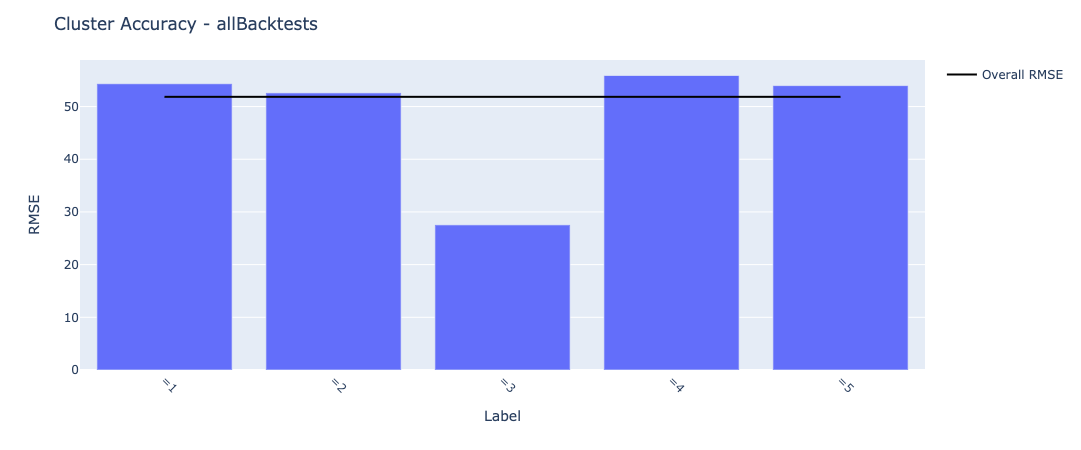

In [77]:
# retrained models
cluster3_acc_retrained2 = ts.get_cluster_acc(df_w_clusters, 
                                 projects3_best_retrained2, 
                                 ts_settings, 
                                 data_subset='allBacktests', 
                                 include_blenders=True, 
                                 metric='RMSE', 
                                 acc_calc=ts.rmse)
ts.plot_cluster_acc(cluster3_acc_retrained2, ts_settings, data_subset='allBacktests', acc_calc=ts.rmse)

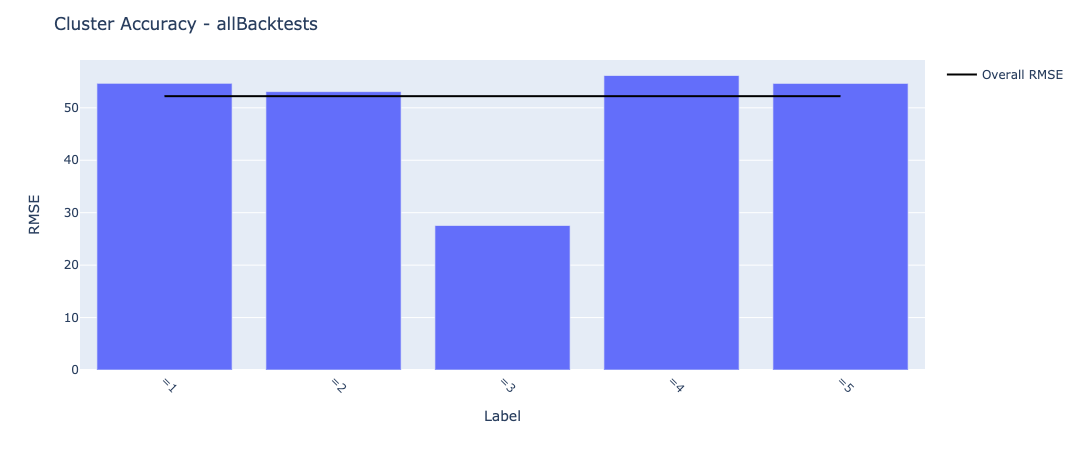

In [78]:
#original models
ts.plot_cluster_acc(cluster3_acc, ts_settings, data_subset='allBacktests', acc_calc=ts.rmse)

### Tiny (51.8 vs 52.2 RMSE) performance improvements across all clusters, not much value provided for the extra compute in this instance. It may provide more lift with other datasets and modeling approaches, but not with this small, messy example dataset.


----------------
# Getting training predictions

### In the model evaluation and interation process, you may want the training predictions. These can easily be obtained via a function 'get_preds_and_actuals':

In [ ]:
%%time
# get predictions for all series from the training data
train_predictions = ts.get_preds_and_actuals(df= df_w_clusters, projects= projects3_best_retrained2, ts_settings= ts_settings, include_blenders= True)

In [ ]:
train_predictions.head()

These downloaded actuals and predictions from the training data provide info on the DR Project, Model, and the predictions for every forecast distance for all dates. Because we have overlap on forecast point and forecast distances, we generally have multiple predictions for each date. 

Generally, you will use the lowest forecast distance to serve as the prediction for a given date, but you can imagine scenarios in which you may actually prefer to use a different forecast distance prediction for date (if for example it was more accurate). The simplest solution is to simply take the mean of any predictions for a given date.

---------
# Plot the actuals and predictions.

####  The following 'plot_preds_and_actuals()' function can plot the average across all series, the top series, a named series, plotting individual forecast distances, and allows for control over the aggregation of predictions for a single date from forecast distance predictions

#### The run-time on this function is highly dependent on the number of DataRobot projects and models are are being used to generate the training predictions. Here, we see that execution-time is approximately 6 minutes for training predictions coming from 9 DataRobot segmented projects.

Getting series predictions from DataRobot...


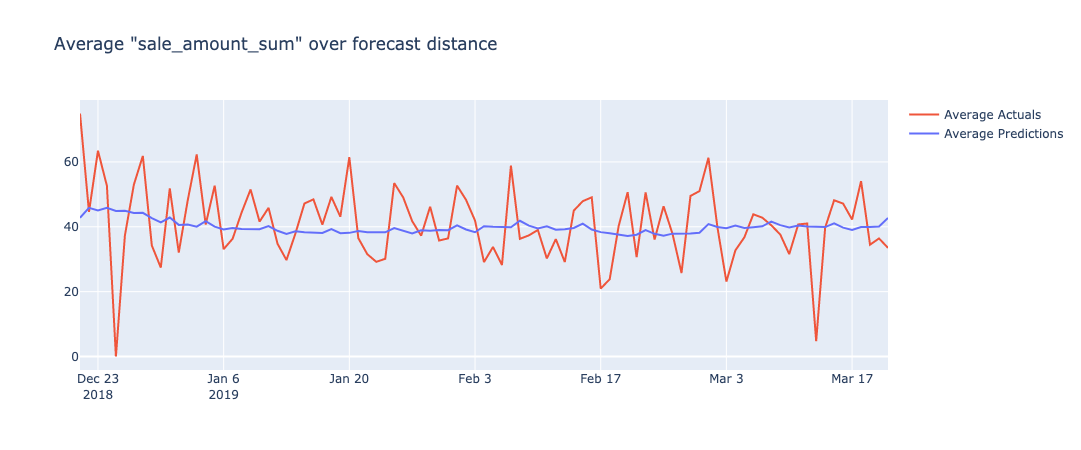

CPU times: user 27.2 s, sys: 945 ms, total: 28.1 s
Wall time: 5min 59s


In [84]:
%%time
# plot the average for all series
ts.plot_preds_and_actuals(df_w_clusters, projects3_best_retrained2, ts_settings, fd_range=None, fd_agg= 'mean', 
                          fd= None, average= True, series_name= None, top=True, data_subset= 'allBacktests', 
                          include_blenders=True, metric= None, acc_calc=ts.rmse)

Getting series predictions from DataRobot...
Plotting series actuals and predictions ...


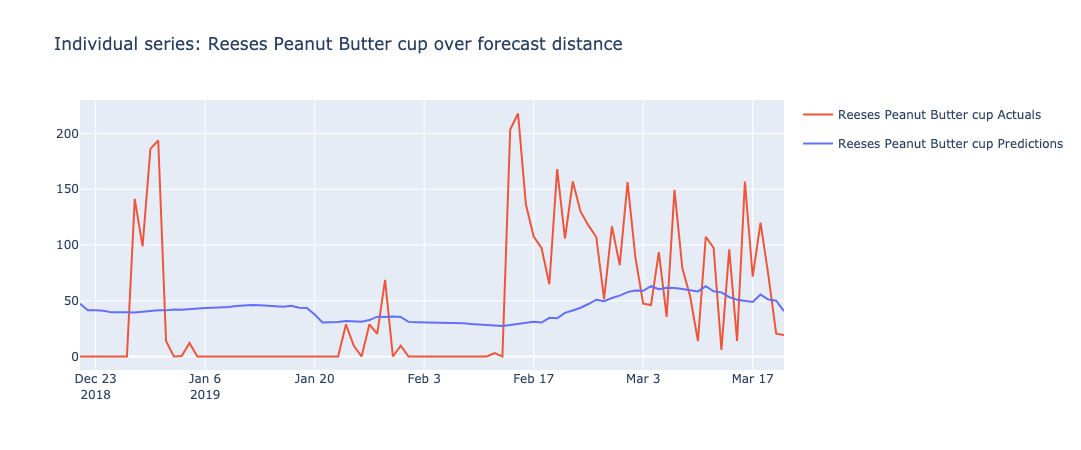

CPU times: user 25.3 s, sys: 465 ms, total: 25.7 s
Wall time: 4min 51s


In [85]:
%%time
# plot the series with the highest average target value (or lowest using top= False)
ts.plot_preds_and_actuals(df_w_clusters, projects3_best_retrained2, ts_settings, fd_range=None, fd_agg= 'mean', 
                          fd= None, average= False, series_name= None, top=True, data_subset= 'allBacktests', 
                          include_blenders=True, metric= None, acc_calc=ts.rmse)

Getting series predictions from DataRobot...
Plotting series actuals and predictions ...


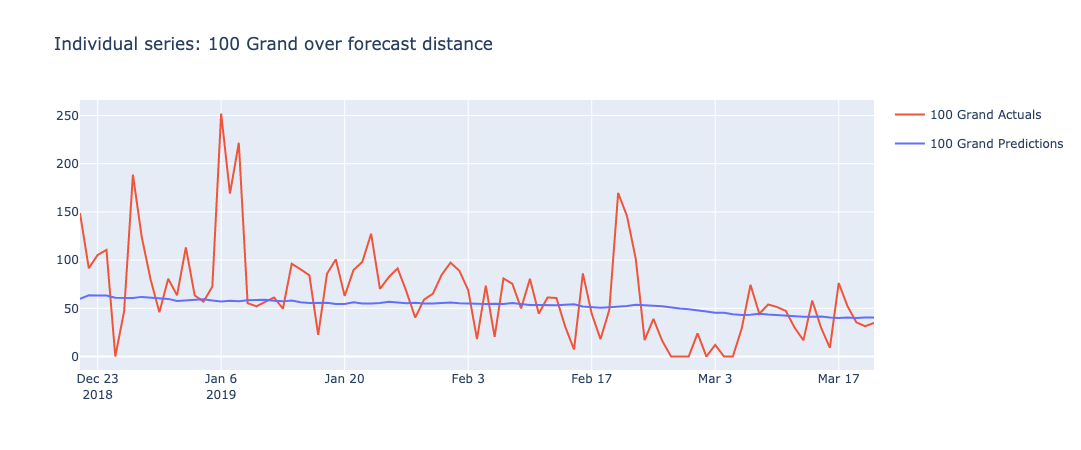

In [86]:
# plot a specific series by name: '100 Grand'
ts.plot_preds_and_actuals(df_w_clusters, projects3_best_retrained2, ts_settings, fd_range=None, fd_agg= 'mean', 
                          fd= None, average= False, series_name= '100 Grand', top=False, data_subset= 'allBacktests', 
                          include_blenders=True, metric= None, acc_calc=ts.rmse)

Getting series predictions from DataRobot...
Plotting series actuals and predictions ...


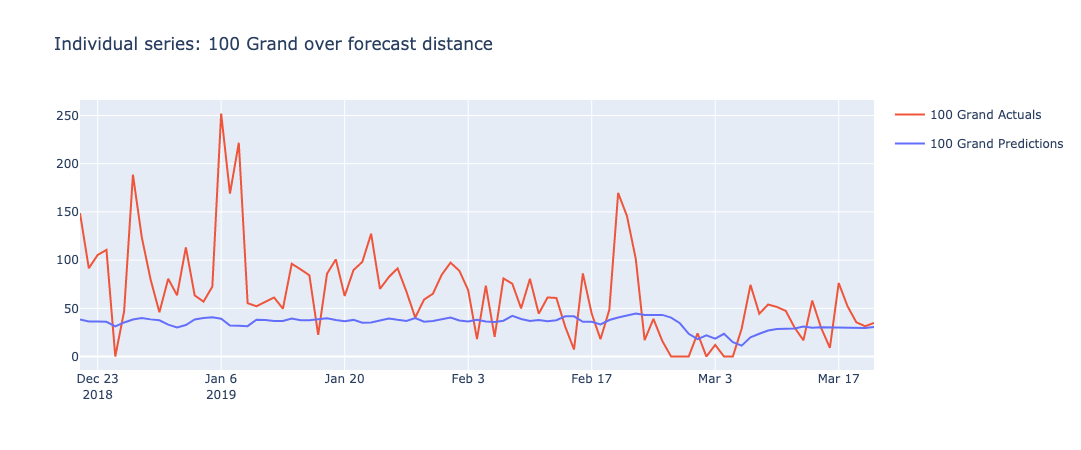

In [87]:
# plot a specific series by name: '100 Grand'
# plot minimum prediction from all fd
ts.plot_preds_and_actuals(df_w_clusters, projects3_best_retrained2, ts_settings, fd_range=None, fd_agg= 'min', 
                          fd= None, average= False, series_name= '100 Grand', top=False, data_subset= 'allBacktests', 
                          include_blenders=True, metric= None, acc_calc=ts.rmse)

Getting series predictions from DataRobot...
Plotting series actuals and predictions ...


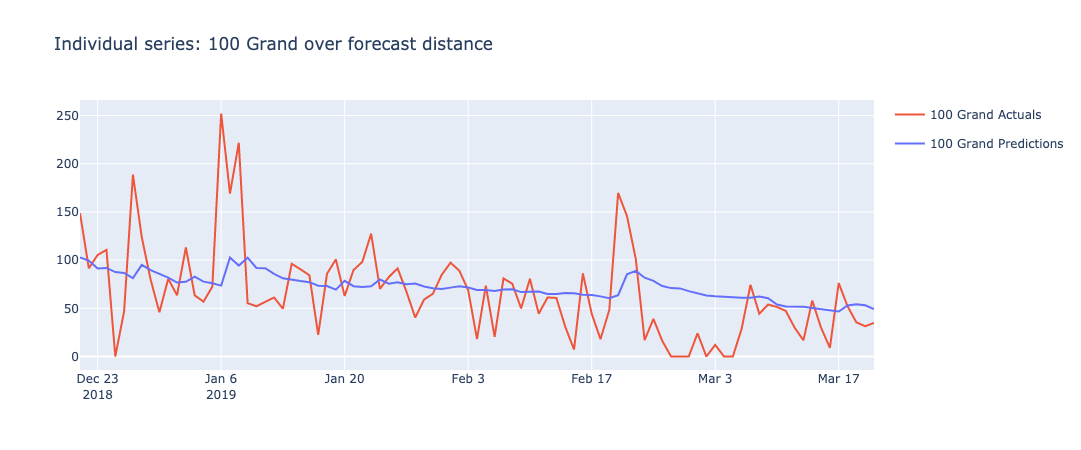

In [88]:
# plot a specific series by name: '100 Grand'
# plot maximum prediction from all fd
ts.plot_preds_and_actuals(df_w_clusters, projects3_best_retrained2, ts_settings, fd_range=None, fd_agg= 'max', 
                          fd= None, average= False, series_name= '100 Grand', top=False, data_subset= 'allBacktests', 
                          include_blenders=True, metric= None, acc_calc=ts.rmse)

Getting series predictions from DataRobot...
Plotting series actuals and predictions ...


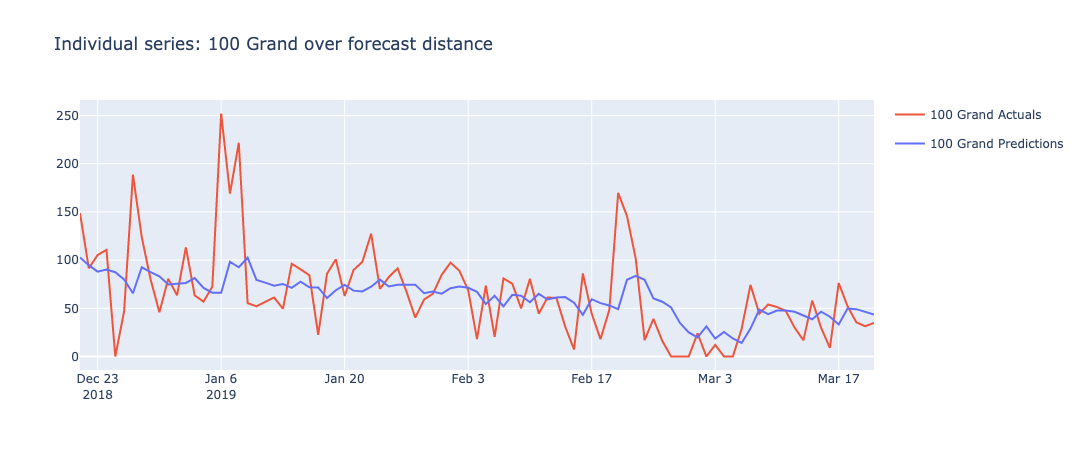

In [90]:
# plot a specific series by name: '100 Grand'
# plot only the fd 1 predictions
ts.plot_preds_and_actuals(df_w_clusters, projects3_best_retrained2, ts_settings, fd_range=None, fd_agg= 'mean', 
                          fd= 1, average= False, series_name= '100 Grand', top=False, data_subset= 'allBacktests', 
                          include_blenders=True, metric= None, acc_calc=ts.rmse)

Getting series predictions from DataRobot...
Plotting series actuals and predictions ...


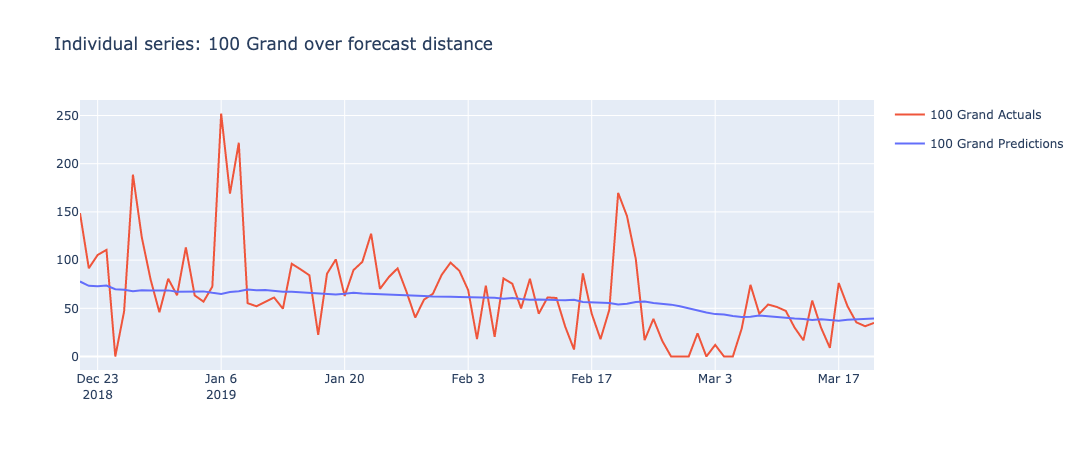

In [91]:
# plot a specific series by name: '100 Grand'
# plot only the first 15 fds (fd_range= (1,15)), averaged for each date
ts.plot_preds_and_actuals(df_w_clusters, projects3_best_retrained2, ts_settings, fd_range= (1, 15), fd_agg= 'mean', 
                          fd= None, average= False, series_name= '100 Grand', top=False, data_subset= 'allBacktests', 
                          include_blenders=True, metric= None, acc_calc=ts.rmse)

Getting series predictions from DataRobot...
Plotting series actuals and predictions ...


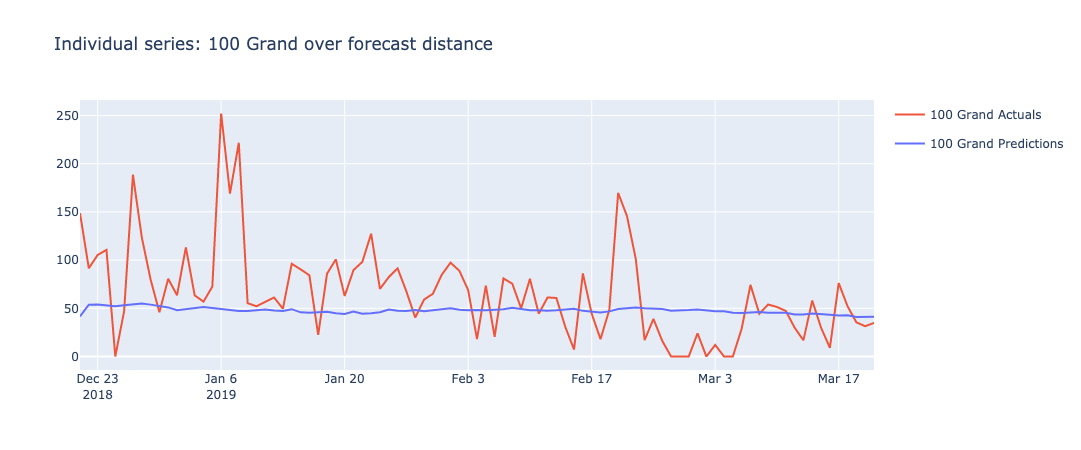

In [92]:
# plot a specific series by name: '100 Grand'
# plot only the last 15 fds (fd_range= (16,30)), averaged for each date
ts.plot_preds_and_actuals(df_w_clusters, projects3_best_retrained2, ts_settings, fd_range= (16, 30), fd_agg= 'mean', 
                          fd= None, average= False, series_name= '100 Grand', top=False, data_subset= 'allBacktests', 
                          include_blenders=True, metric= None, acc_calc=ts.rmse)

----------------
# Evaluating performance on Forecast Distances and Accuracy over Time



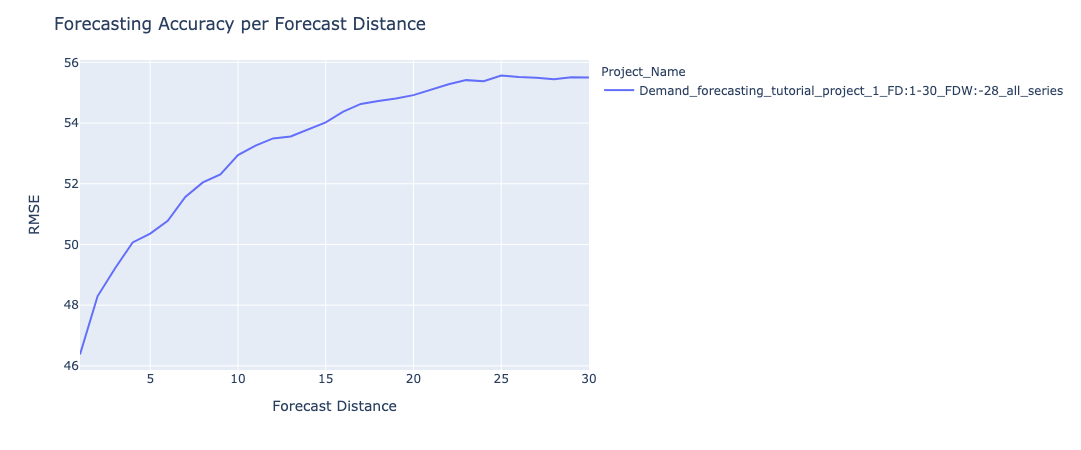

In [98]:
# Project 1
ts.plot_fd_accuracy_by_cluster(df_w_clusters, project_scores, projects_best, ts_settings, data_subset='allBacktests', metric='RMSE')

#### When evaluating accuracy over time, it may be relevant to select a 'relative to baseline' metric (such as MAE, MAPE, or SMAPE) to understand how well the model performs over time. This provides a context by which we can understand how or why our models might not have consistent performance over time. Generally, you would expect that a model becomes less accurate over time, but that does not always hold with different data sets.

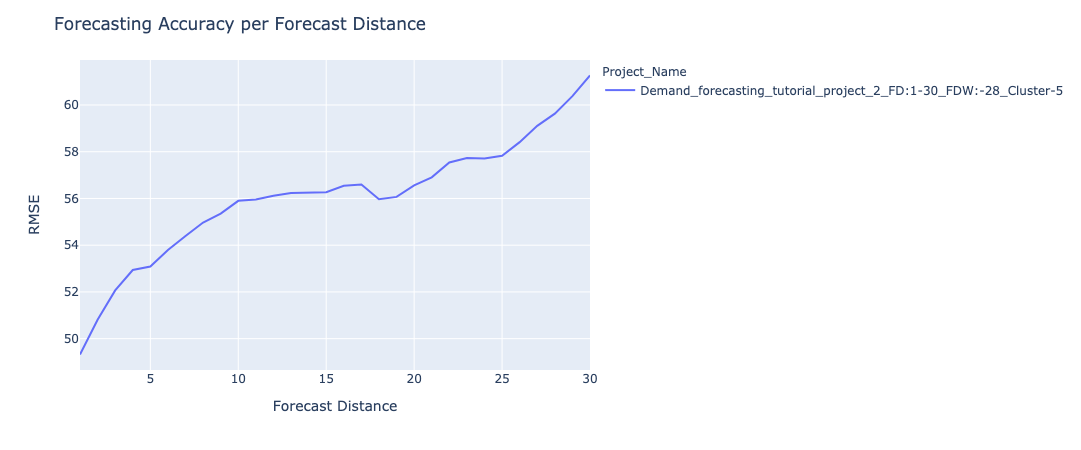

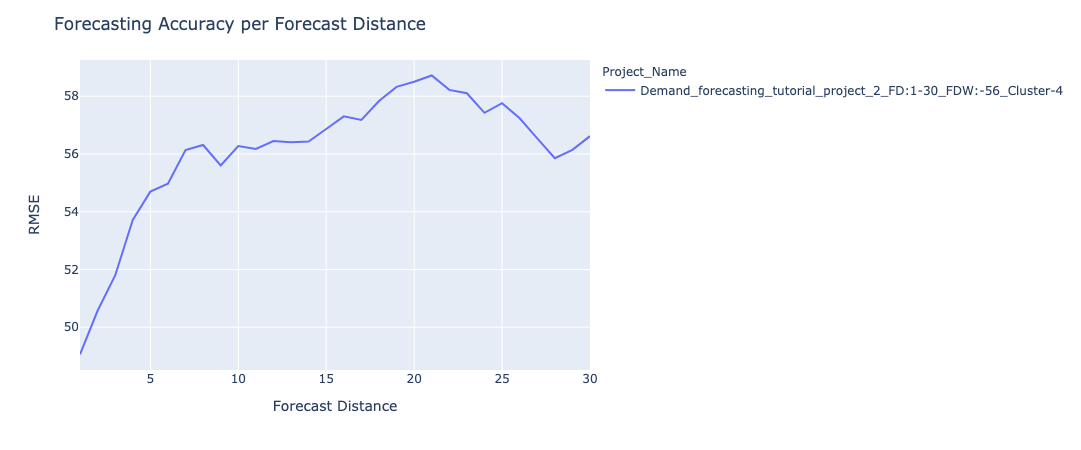

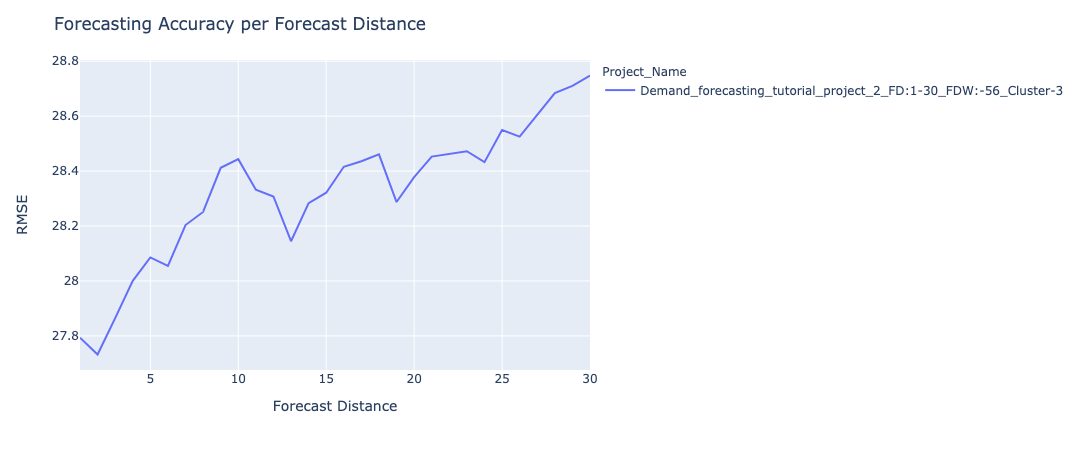

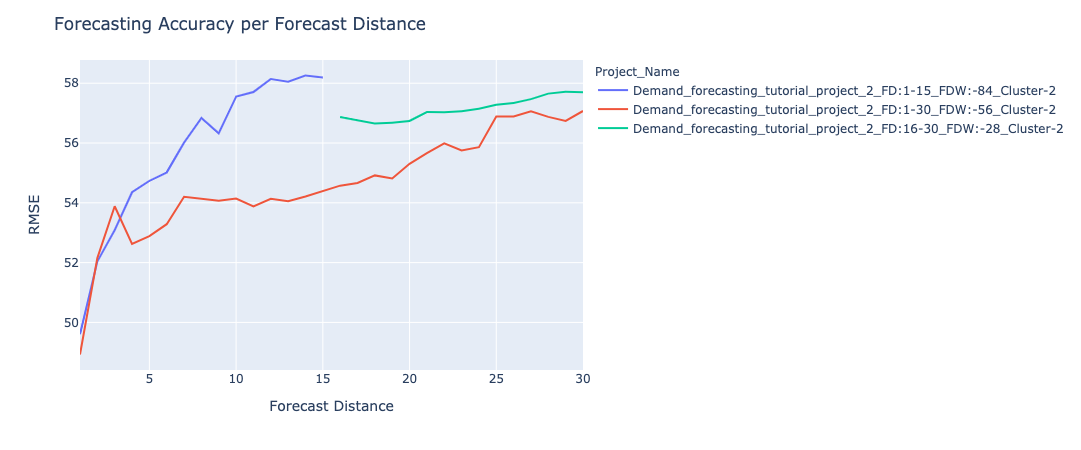

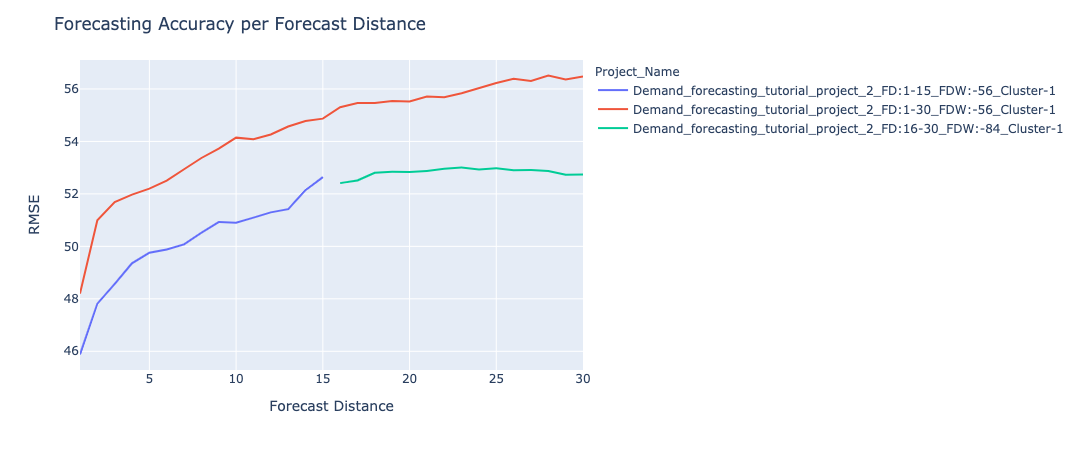

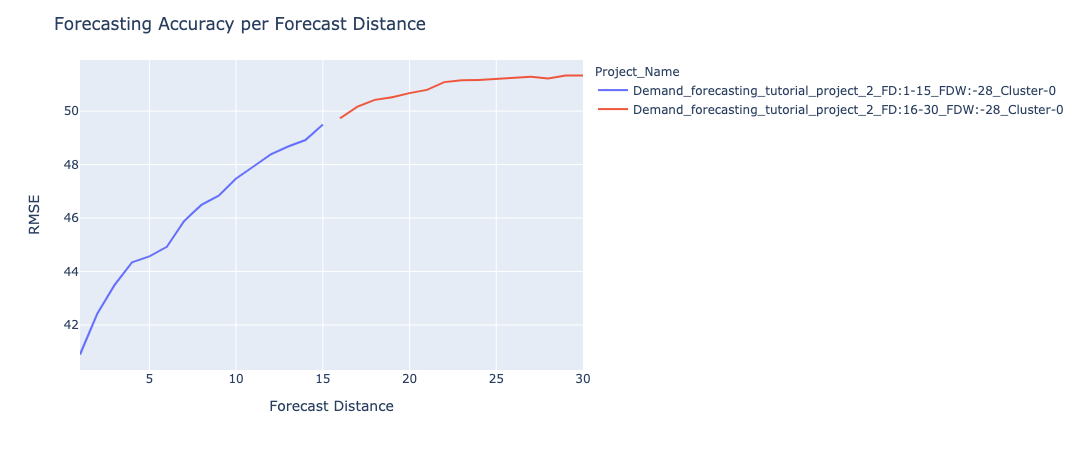

In [99]:
# Project 2
# you'll notice a few extra lines in these plots. This is because I didn't use a fully-unique prefix-for these projects
# the datarobot_ts_helpers package automatically integrates predictions and performance from DR projects provided
# even if they don't really correspond to the same 'experiment'
# this is part of the reason it is so important to use a unique prefix-name for your 'experiments'
ts.plot_fd_accuracy_by_cluster(df_w_clusters, project2_scores, projects2_best, ts_settings, data_subset='allBacktests', metric='RMSE')

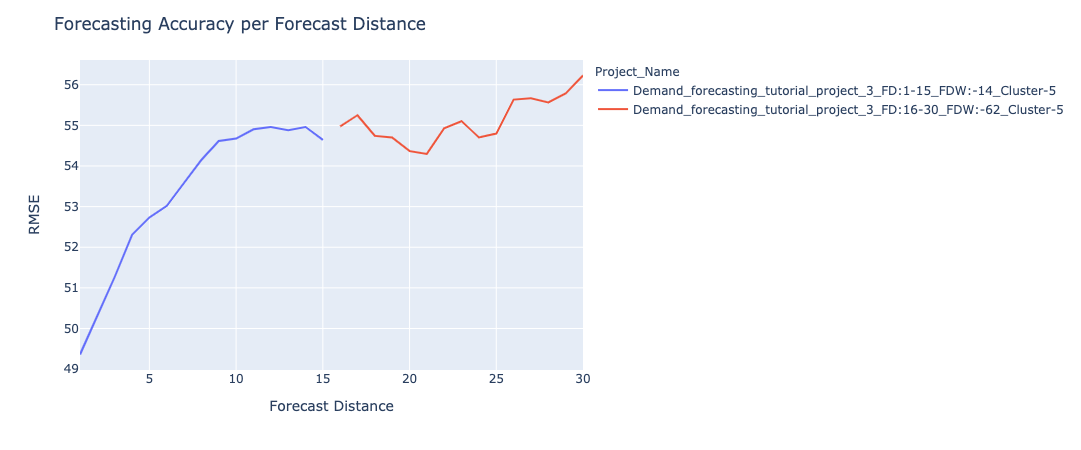

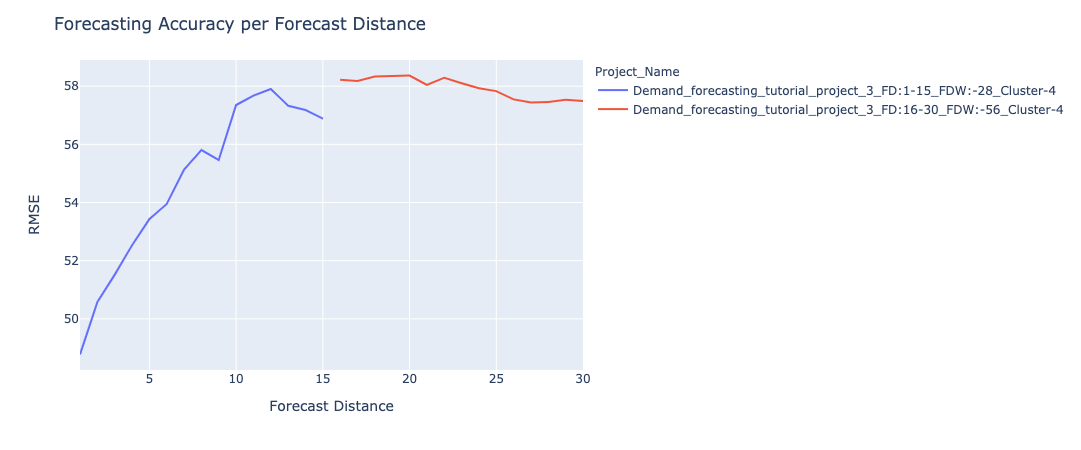

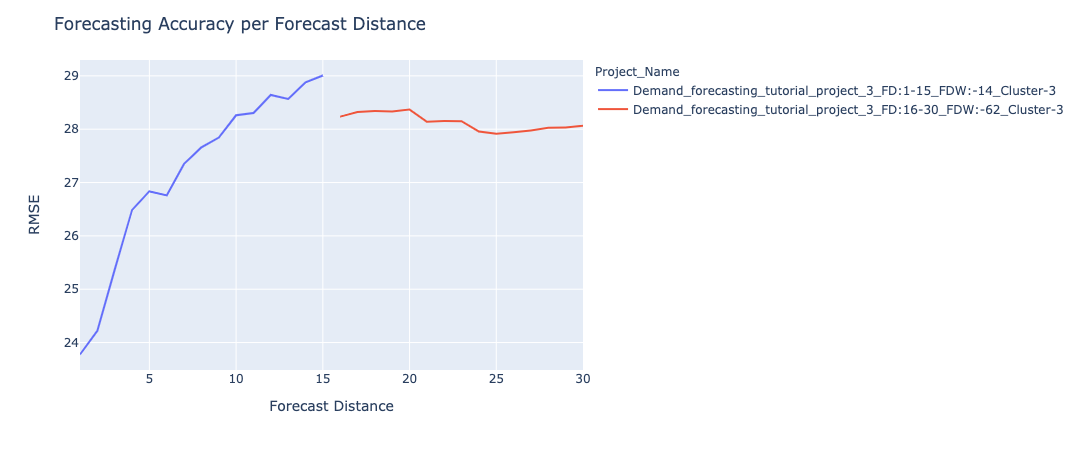

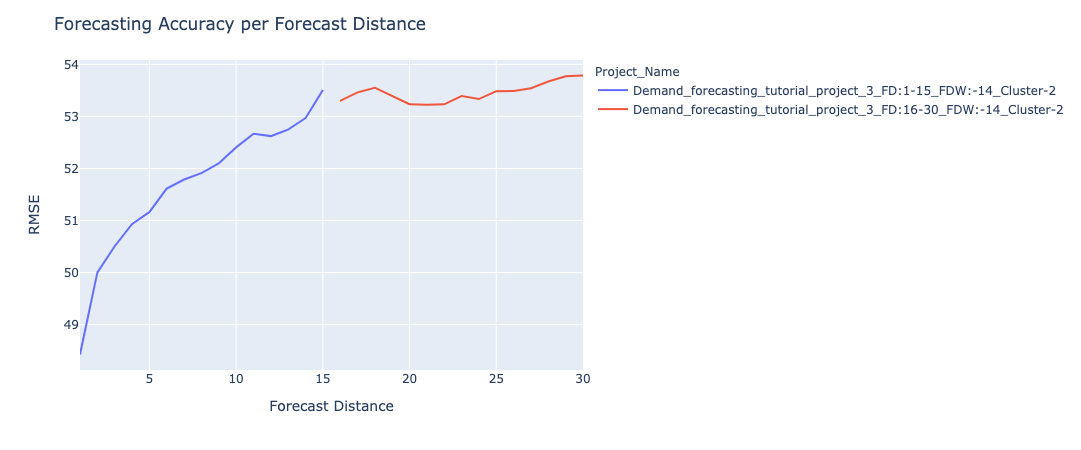

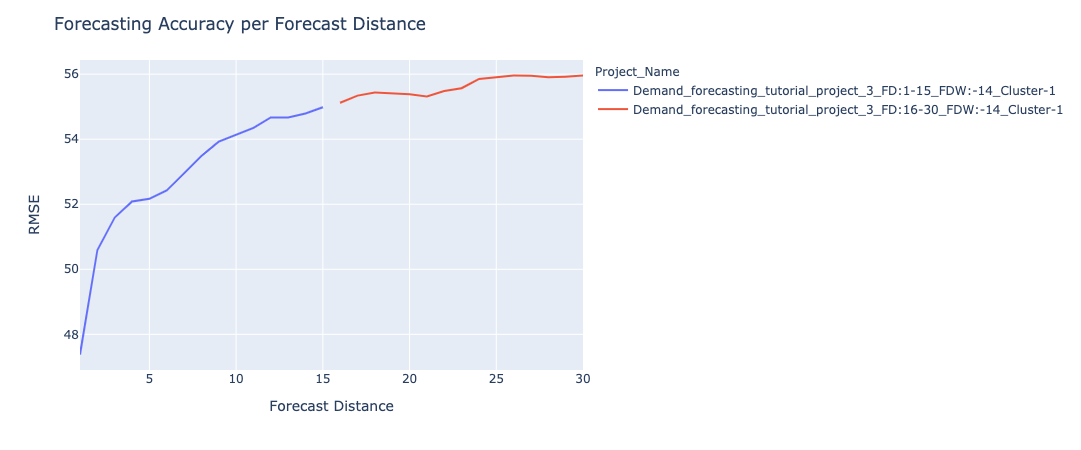

CPU times: user 26.9 s, sys: 718 ms, total: 27.6 s
Wall time: 4min 42s


In [103]:
%%time
# Project 3
ts.plot_fd_accuracy_by_cluster(df_w_clusters, project3_scores_retrained2, projects3_best_retrained2, 
                               ts_settings, data_subset='allBacktests', metric='RMSE')

--------------
# Getting predictions from un-deployed models

#### You may want to get predictions from un-deployed models, but there are limits of total volume and frequency of scoring for un-deployed models

In [108]:
# Get series and cluster pairs for predictions
series_to_clusters_dict = ts.series_to_clusters(df_w_clusters, ts_settings, split_col='Cluster')


# create a dictionary to add cluster labels for series
# if we have new series at this point, we would need to choose a cluster to manually assign the series into
clusters_to_series_dict = ts.clusters_to_series(df_w_clusters, ts_settings)

In [105]:
# Load and prep scoring data
# The last 31 days of data were withheld from the model training process to be used here for predictions
scoring_data = pd.read_csv('data/data_for_predictions.csv', index_col= 0)
scoring_data['Cluster'] = scoring_data[series_id].map(series_to_clusters_dict)

In [106]:
scoring_data.head()

item_name        date  package_id_min  package_id_max  \
436           100 Grand  2019-04-21    1.700005e+09    1.700005e+09   
1274       3 Musketeers  2019-04-21    1.700005e+09    1.700005e+09   
1629         Almond Joy  2019-04-21             NaN             NaN   
2605  Haribo Gold Bears  2019-04-21             NaN             NaN   
3813   Hersheys Krackel  2019-04-21    1.700005e+09    1.700005e+09   

      package_id_unique       campaign_min     campaign_max  campaign_unique  \
436                 2.0  discount_type_374  discount_type_1              2.0   
1274                2.0   discount_type_34  discount_type_1              3.0   
1629                NaN                NaN              NaN              NaN   
2605                NaN                NaN              NaN              NaN   
3813                1.0    discount_type_2  discount_type_2              1.0   

      qty_min  qty_mean  qty_max  qty_stdev  qty_unique  qty_sum  \
436      1.96    4.9210     7.88   2.669359        10.0    49.21   
1274     3.93    4.1975     4.96   0.508486         4.0    16.79   
1629      NaN       NaN      NaN        NaN         NaN      NaN   
2605      NaN       NaN      NaN        NaN         NaN      NaN   
3813    46.94   46.9400    46.94        NaN         1.0    46.94   

      unit_price_min  unit_price_mean  unit_price_max  unit_price_stdev  \
436             1.12            2.106            2.99          0.591649   
1274            0.73            1.570            2.67          0.978809   
1629             NaN              NaN             NaN               NaN   
2605             NaN              NaN             NaN               NaN   
3813            1.53            1.530            1.53               NaN   

      unit_price_unique  unit_price_sum  sale_amount_min  sale_amount_mean  \
436                10.0           21.06             3.58           10.0250   
1274                4.0            6.28             3.01            6.3675   
1629                NaN             NaN              NaN               NaN   
2605                NaN             NaN              NaN               NaN   
3813                1.0            1.53            71.82           71.8200   

      sale_amount_max  sale_amount_stdev  sale_amount_unique  sale_amount_sum  \
436             19.18           5.731853                10.0           100.25   
1274            10.49           3.639912                 4.0            25.47   
1629              NaN                NaN                 NaN             0.00   
2605              NaN                NaN                 NaN             0.00   
3813            71.82                NaN                 1.0            71.82   

      day store_category category transaction  aggregated_total_count  \
436   Sun         Type_B   Retail        Good                    10.0   
1274  Sun         Type_B   Retail        Good                     4.0   
1629  NaN            NaN      NaN         NaN                     NaN   
2605  NaN            NaN      NaN         NaN                     NaN   
3813  Sun         Type_B   Retail        Good                     1.0   

      metro_area  county_1  total_market_sales  metro_area_ffill  \
436          NaN       NaN                 NaN        45077335.0   
1274         NaN       NaN                 NaN        45077335.0   
1629         NaN       NaN                 NaN               NaN   
2605         NaN       NaN                 NaN               NaN   
3813         NaN       NaN                 NaN        45077335.0   

      metro_area_interpolate  county_1_ffill  county_1_interpolate  \
436             2.433593e+07      35328169.0          1.079177e+07   
1274            2.429281e+07      35328169.0          1.074076e+07   
1629                     NaN             NaN                   NaN   
2605                     NaN             NaN                   NaN   
3813            2.424969e+07      35328169.0          1.068975e+07   

      total_market_sa

In [109]:
# add cross-series features and correct column type
scoring_data = ts.create_cross_series_features(scoring_data, 
                                           group=[date_col,'Cluster'], 
                                           cols=[target], 
                                           funcs=['mean','std', 'min', 'max'])
scoring_data[date_col] = pd.to_datetime(scoring_data[date_col])

In [116]:
%%time
stats = ts.get_project_stats(projects3_best_retrained2, n_models=1, cluster_to_series_map= clusters_to_series_dict, 
                             split_col= 'Cluster', prefix= 'Demand_forecasting_tutorial_project_3', metric='RMSE', data_subset= 'holdout')
stats

CPU times: user 3.53 s, sys: 296 ms, total: 3.82 s
Wall time: 2min 53s


Project_Name  \
0   Demand_forecasting_tutorial_project_3_FD:1-15_...   
1   Demand_forecasting_tutorial_project_3_FD:16-30...   
2   Demand_forecasting_tutorial_project_3_FD:1-15_...   
3   Demand_forecasting_tutorial_project_3_FD:1-15_...   
4   Demand_forecasting_tutorial_project_3_FD:16-30...   
5   Demand_forecasting_tutorial_project_3_FD:1-15_...   
6   Demand_forecasting_tutorial_project_3_FD:16-30...   
7   Demand_forecasting_tutorial_project_3_FD:1-15_...   
8   Demand_forecasting_tutorial_project_3_FD:16-30...   
9   Demand_forecasting_tutorial_project_3_FD:1-15_...   
10  Demand_forecasting_tutorial_project_3_FD:1-15_...   
11  Demand_forecasting_tutorial_project_3_FD:16-30...   
12  Demand_forecasting_tutorial_project_3_FD:1-15_...   
13  Demand_forecasting_tutorial_project_3_FD:16-30...   
14  Demand_forecasting_tutorial_project_3_FD:1-15_...   
15  Demand_forecasting_tutorial_project_3_FD:16-30...   
16  Demand_forecasting_tutorial_project_3_FD:1-15_...   

                  Project_ID Cluster     FD  FDW  \
0   60396f2123f5d98fafc15d24       5   1-15  -14   
1   60396e10ea5b280bbf55bf99       4  16-30  -56   
2   60396ab5cbbfae8d6a55bf14       4   1-15  -28   
3   60395ddf23f5d98fafc15ce5       3   1-15  -14   
4   603958abea5b280bbf55bedd       2  16-30  -14   
5   603957b9ea5b280bbf55bece       2   1-15  -14   
6   60395283cbbfae8d6a55bec4       1  16-30  -14   
7   60395165ea5b280bbf55be77       1   1-15  -14   
8   5f6d5041749459033e216535       5  16-30  -62   
9   5f6d4a8cddc1ac034d177044       5   1-15  -14   
10  5f6d445bddc1ac034d17703e       4   1-15  -28   
11  5f6d4018749459031e2163ac       3  16-30  -62   
12  5f6d390fddc1ac036e177174       3   1-15  -14   
13  5f6d3161ddc1ac034d176ffa       2  16-30  -14   
14  5f6d3008ddc1ac034d176fdd       2   1-15  -14   
15  5f6d27ff749459033e216368       1  16-30  -14   
16  5f6d2682ddc1ac036e177044       1   1-15  -14   

                                           Model_Type  \
0     Ridge Regressor with Forecast Distance Modeling   
1                   Vector Autoregressive Model (VAR)   
2                   Vector Autoregressive Model (VAR)   
3   Temporal Hierarchical Model with Elastic Net a...   
4     Ridge Regressor with Forecast Distance Modeling   
5   eXtreme Gradient Boosting Regressor with Early...   
6   Performance Clustered eXtreme Gradient Boosted...   
7                              RandomForest Regressor   
8   RandomForest Regressor using Linearly Decaying...   
9   Zero-Inflated Light Gradient Boosted Trees Reg...   
10                  Vector Autoregressive Model (VAR)   
11  Ridge Regressor using Linearly Decaying Weight...   
12  Temporal Hierarchical Model with Elastic Net a...   
13  eXtreme Gradient Boosted Trees Regressor with ...   
14    Ridge Regressor with Forecast Distance Modeling   
15  eXtreme Gradient Boosting on ElasticNet Predic...   
16                             RandomForest Regressor   

                    Model_ID  \
0   60399e867952a337f2850bc6   
1   60396f18d3753806950fb742   
2   60396bc69b8376f1314cf9ef   
3   603963ae298757a4be335a3a   
4   603992d93fb1e9d0865c9c96   
5   60399327a59038559f850c1c   
6   6039a01af4d6a8abff5c9e19   
7   6039527941dde8320c0564e2   
8   5f7c86fad6e71631dd38d876   
9   5f6d4bb1dd02640a7f34f9d7   
10  5f6d45aa07f10a1696aa987f   
11  5f7c878b11bc9b004ce9baa0   
12  5f7cb26908d9693471a69455   
13  603999bf9ccde9f9945c9bc4   
14  5f6d315963f95a1501c0ed26   
15  5f6d292051786d9c6efe279a   
16  5f6d27f622a74a68b5419571   

                                               Series  
0       [Reeses Miniatures, Reeses Peanut Butter cup]  
1   [Hersheys Milk Chocolate, Kit Kat, Nestle Butt...  
2   [Hersheys Milk Chocolate, Kit Kat, Nestle Butt...  
3   [Air Heads, Baby Ruth, Gobstopper, Mike & Ike,...  
4   [3 Musketeers, Almond Joy, Haribo Gold Bears, ...  
5   [3 Musketeers, Almond Joy, Haribo Gold Bears, ...  
6   [100 Grand, M&Ms, Milk Duds, Milky Way, Mr Goo...  
7   [100 Grand, M&Ms, Mil

In [117]:
%%time
# get the top models from all projects
models_best = ts.get_top_models_from_projects(projects3_best_retrained2, n_models=1, data_subset='holdout', 
                                              include_blenders=True, metric='RMSE')

# configure the forecast point
forecast_point = df_w_clusters['date'].max()

CPU times: user 3.14 s, sys: 42.9 ms, total: 3.18 s
Wall time: 3min 19s


In [118]:
# what models were selected?
models_best

[DatetimeModel('Ridge Regressor with Forecast Distance Modeling'),
 DatetimeModel('Vector Autoregressive Model (VAR)'),
 DatetimeModel('Vector Autoregressive Model (VAR)'),
 DatetimeModel('Temporal Hierarchical Model with Elastic Net and XGBoost'),
 DatetimeModel('Ridge Regressor with Forecast Distance Modeling'),
 DatetimeModel('eXtreme Gradient Boosting Regressor with Early Stopping and New Series Support'),
 DatetimeModel('Performance Clustered eXtreme Gradient Boosted Trees Regressor'),
 DatetimeModel('RandomForest Regressor'),
 DatetimeModel('RandomForest Regressor using Linearly Decaying Weights'),
 DatetimeModel('Zero-Inflated Light Gradient Boosted Trees Regressor with Early Stopping (Poisson Loss)'),
 DatetimeModel('Vector Autoregressive Model (VAR)'),
 DatetimeModel('Ridge Regressor using Linearly Decaying Weights with Forecast Distance Modeling'),
 DatetimeModel('Temporal Hierarchical Model with Elastic Net and XGBoost'),
 DatetimeModel('eXtreme Gradient Boosted Trees Regres

In [121]:
%%time
# get predictions from undeployed models
preds = ts.get_or_request_predictions(models= models_best, 
                                   project_stats= stats, 
                                   scoring_df= scoring_data,
                                   training_df= df_w_clusters,
                                   ts_settings= ts_settings,
                                   start_date= None, 
                                   end_date= None, 
                                   forecast_point= forecast_point)


DatetimeModel('Ridge Regressor with Forecast Distance Modeling')
For series:  ['Reeses Miniatures', 'Reeses Peanut Butter cup']
Training Data Start Date:  2017-05-04 00:00:00+00:00
Training Data End Date:  2019-02-07 00:00:00+00:00
FDW start for predictions:  2019-04-06 00:00:00
FDW end for predictions:  2019-04-20 00:00:00
Forecast point:  2019-04-20 00:00:00
*** Values required to generate FDW for predictions are missing from the scoring_df and will be added from the training_df ***
Adding historical data from 2019-04-06 00:00:00 to 2019-04-21 00:00:00
Uploading scoring dataset with 92 rows for Project Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-5

DatetimeModel('Vector Autoregressive Model (VAR)')
For series:  ['Hersheys Milk Chocolate', 'Kit Kat', 'Nestle Butterfinger', 'Reeses pieces', 'Reeses stuffed with pieces', 'Snickers', 'Twix']
Training Data Start Date:  2017-05-04 00:00:00+00:00
Training Data End Date:  2019-02-07 00:00:00+00:00
FDW start for predictions

In [122]:
%%time
preds_and_actuals = ts.merge_preds_and_actuals(preds, scoring_data, ts_settings)
undeployed_error = ts.rmse(preds_and_actuals['prediction'],preds_and_actuals[ts_settings['target']])
print('RMSE: ',undeployed_error)

RMSE:  51.2639902136188
CPU times: user 13.2 ms, sys: 12 ms, total: 25.2 ms
Wall time: 36.5 ms


-----------------
# Model deployment

### Instead of getting predictions on undeployed models, we can quickly deploy those models and get predicitons

In [123]:
# deploy desired models using default settings
test_deployments = ts.deploy_models(models_best)

Deployment of Ridge Regressor with Forecast Distance Modeling into Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-5 successful!
Deployment of Vector Autoregressive Model (VAR) into Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-56_Cluster-4 successful!
Deployment of Vector Autoregressive Model (VAR) into Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-28_Cluster-4 successful!
Deployment of Temporal Hierarchical Model with Elastic Net and XGBoost into Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-3 successful!
Deployment of Ridge Regressor with Forecast Distance Modeling into Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-14_Cluster-2 successful!
Deployment of eXtreme Gradient Boosting Regressor with Early Stopping and New Series Support into Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-2 successful!
Deployment of Performance Clustered eXtreme Gradient Boosted Trees Regressor into Demand_forecasting_tutorial_project_3_FD:16-30

In [124]:
# check the list of deployments just created
test_deployments

[Deployment(Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-5),
 Deployment(Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-56_Cluster-4),
 Deployment(Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-28_Cluster-4),
 Deployment(Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-3),
 Deployment(Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-14_Cluster-2),
 Deployment(Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-2),
 Deployment(Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-14_Cluster-1),
 Deployment(Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-1),
 Deployment(Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-62_Cluster-5),
 Deployment(Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-5),
 Deployment(Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-28_Cluster-4),
 Deployment(Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-62_Cluster-3),
 Deployment(Demand_forecasting_tutorial_project_3_FD:1-15_F

In [125]:
%%time
# get predictions from deployed models
test = ts.get_or_request_predictions(models= None, # for a deployment, no models need to be specified
                                   project_stats= stats, 
                                   scoring_df= scoring_data,
                                   training_df= df_w_clusters,
                                   ts_settings= ts_settings,
                                   deployments= test_deployments, # instead specify a list of deployment objects
                                   start_date= None, 
                                   end_date= None, 
                                   forecast_point= forecast_point)

Accessing model from Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-5 deployment
Accessing model from Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-56_Cluster-4 deployment
Accessing model from Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-28_Cluster-4 deployment
Accessing model from Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-3 deployment
Accessing model from Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-14_Cluster-2 deployment
Accessing model from Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-2 deployment
Accessing model from Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-14_Cluster-1 deployment
Accessing model from Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-1 deployment
Accessing model from Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-62_Cluster-5 deployment
Accessing model from Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-5 deployment
Accessing model from Demand_forecast

In [126]:
%%time
deployed_preds_and_actuals = ts.merge_preds_and_actuals(test, scoring_data, ts_settings)
deployed_error = ts.rmse(deployed_preds_and_actuals['prediction'],deployed_preds_and_actuals[ts_settings['target']])
print('Deployed RMSE: ', deployed_error)
print('Un-deployed RMSEL ', undeployed_error)

Deployed RMSE:  51.2639902136188
Un-deployed RMSEL  51.2639902136188
CPU times: user 13 ms, sys: 2.38 ms, total: 15.4 ms
Wall time: 13.3 ms


-------------
# Thats all for now.

### Please reach out to jarred.bultema@datarobot.com with any questions, comments, or bugs